# Анализ лояльности пользователей Яндекс Афиши

- Автор: Недведь Мария Олеговна
- Дата: 27.01.2026

### Цели и задачи проекта

Провести исследовательский анализ данных билетной площадки **Яндекс Афиша**, чтобы выяснить, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Опираясь на результаты исследовательского анализа данных, необходимо сформулировать рекомендации для заказчика.

Задачи: 
1. Загрузить данные из базы данных и познакомиться с их содержимым
2. Провести предобработку данных
3. Сформировать датасет, содержащий профили пользователей
4. Провести исследовательский анализ данных
5. Сформулировать выводы по проведённому анализу
6. Опубликовать проект в GitHub

### Описание данных

Для анализа представлен датасет <u>df</u> с информацией о заказах клиентов билетной площадки **Яндекс Афиша**, составленный на основе выгрузки из базы данных; данные представлены за период с июня 2024 года по октябрь 2024 года. 
Также представлен датасет <u>df_tenge</u> с информацией о курсе российского рубля к казахстанскому тенге за 2024 год.

1. Описание датасета <u>df</u> (выгрузка информации произведена из базы данных):  
- `user_id` — уникальный идентификатор пользователя, совершившего заказ
- `device_type_canonical` — тип устройства, с которого был оформлен заказ
- `order_id` — уникальный идентификатор заказа
- `order_dt` — дата создания заказа
- `order_ts` — дата и время создания заказа
- `currency_code` — валюта оплаты
- `revenue` — выручка от заказа
- `tickets_count` — количество купленных билетов
- `days_since_prev` — количество дней от предыдущей покупки пользователя
- `event_id` — уникальный идентификатор мероприятия
- `event_name` - название мероприятия
- `service_name` — название билетного оператора
- `event_type_main` — основной тип мероприятия
- `region_name` — название региона, в котором прошло мероприятие
- `city_name` — название города, в котором прошло мероприятие.

2. Описание датасета <u>df_tenge</u> (информация о курсе валют):  
- `data` - дата актуального курса валют
- `nominal` - номинал в казахстанском тенге
- `curs` - курс в российских рублях
- `cdx` - код валюты.


_____

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** 

---


 Устанавливаю необходимые библиотеки:
 - SQLAlchemy
 - psycopg2

In [1]:
#!pip install sqlalchemy
#!pip install psycopg2-binary

In [2]:
#!pip install phik

Импортирую необходимые библиотеки и и функцию create_engine()  из библиотеки SQLAlchemy для подключения к базе данных и выполнения SQL-запроса:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine

Запишем данные для подключения к базе данных `data-analyst-afisha` в объект db_config:

In [4]:
db_config = {
    's_user': os.getenv('STUDENT_USER'),
    'pwd': os.getenv('PASSWORD'),
    'host': os.getenv('HOST'),
    'port': os.getenv('PORT'),
    'db': os.getenv('DB')
}

Формирую строку для подключения, которая содержит информацию об используемой СУБД, а также все данные для авторизации:

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['s_user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Строку с данными для подключения передаю функции create_engine():

In [6]:
engine = create_engine(connection_string)

Запрос запишем в переменную query:

In [7]:
query = '''
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk AS order_dt,
       created_ts_msk AS order_ts,
       currency_code,
       revenue,
       tickets_count,
       EXTRACT(DAY FROM created_dt_msk - LAG(created_dt_msk)OVER(PARTITION BY user_id ORDER BY created_dt_msk ASC)) AS days_since_prev,
       p.event_id,
       e.event_name_code AS event_name,
       e.event_type_main,
       p.service_name,
       (SELECT region_name FROM afisha.regions r WHERE r.region_id = c.region_id),
       c.city_name
FROM afisha.purchases p 
JOIN afisha.events e USING (event_id)
JOIN afisha.city c USING (city_id)
WHERE device_type_canonical IN ('mobile', 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id 
''' 

Результат выдачи SQL-запроса запишем в датафрейм, переменную <u>df</u>:

In [8]:
df = pd.read_sql_query(query, con=engine)

Создаю копию датасета до преобразований:

In [9]:
tmp = df.copy()
initial_len_df = len(tmp)

---

**Задача 1.2:** 

---

Вывожу первые пять строк датафрейма для обзора:

In [10]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


Информация о названиях столбцов и проверка, все ли необходимые столбцы выгружены согласно заданию:

In [11]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name'],
      dtype='object')

Названия и требуемая в задании информация выгружены корректно.

Общая информация о полученном датафрейме:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

### Промежуточный вывод:

**Датафрейм <u>df</u> содержит**:
- 290 611 строк
- 15 столбцов

Названия столбцов представлены в нижнем регистре, используется snake_case. Предобработка названий столбцов не требутеся.

**Столбцы представлены следующими типами данных**:
- 8 столбцов имеют тип данных object
- 3 столбца имеют целочисленный тип данных int64
- 2 столбца имеют вещественный тип данных  float64
- 2 столбца имеют тип данных datetime64[ns]

Последующая предобработка данных заключается в:
- Оптимизация типа данных: `tickets_count` хранит значения от 1 до 57 (количество купленных билетов) -> можно понизить тип данных до int8. Также можно оптимизировать типы данных столбцов: `revenue`, `event_id`, `order_id`.
- Изменение типа данных: `days_since_prev` хранит целочисленные значения (количество дней от предыдущей покупки пользователя. Также по условию задания этот столбец должен быть целочисленным) - поэтому тип нужно изменить с float64 на int оптимальной размерности.

**Пропуски имеются в столбце `days_since_prev`, все остальные столбцы пропусков не содержат.**

*Поскольку столбец `days_since_prev` содержит пропуски, то дальнейшее преобразование типа данных возможно в nullable integer dtype*

**Датафрейм использует 33.3+ MB оперативной памяти.**

##### 

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** 

---


Выгружаю в переменную <u>df_tenge</u> датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю: 

In [13]:
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Вывожу первые и последние пять строк для обзора получившегося датафрейма:

In [14]:
df_tenge

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


Размер датафрейма <u>df_tenge</u>

In [15]:
df_tenge.shape

(357, 4)

Типы данных столбцов:

In [16]:
df_tenge.dtypes

data        object
nominal      int64
curs       float64
cdx         object
dtype: object

Столбец `data` содержит данные о датах, поэтому тип этого столбца нужно изменить на соотвествующий (datetime64[ns]):

In [17]:
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

Вновь проверяю типы данных столбцов после изменения:

In [18]:
df_tenge.dtypes

data       datetime64[ns]
nominal             int64
curs              float64
cdx                object
dtype: object

Датафрейм <u>df_tenge</u> содержит информацию по каждому дню каждого месяца за 2024 год.  
Например, курс на 2024-01-10: 100 тенге = 19.9391 руб. Соответственно, 1 тенге = 19.9391/100 руб. Можно воспользоваться этой формулой для расчета нового столбца `revenue_rub`, где данные будут представлены суммами выручки только в российских рублях.

Для того, чтобы не перебирать построчно значения в столбцах с датами и сравнивать их, я создам объединенный датафрейм. Объединяю по значениям дат в обоих датафреймах:

In [19]:
df_merged = df.merge(df_tenge, left_on='order_dt', right_on='data', how='left')

Задам функцию, которая на вход будет принимать строку row и в случае, если валюта kzt, то в новом столбце по формуле будет рассчитано новое значение в российских рублях. Если в строке изначально значение было в российских рублях, то данные переносятся в новый столбец без изменений:

In [20]:
def convert_currency(row):
    #Значение в столбце currency_code российские рубли
    if row['currency_code'] == 'rub':
        return row['revenue']
    #Значение в столбце currency_code тенге
    elif row['currency_code'] == 'kzt':
        return round(row['revenue'] * (row['curs'] / row['nominal']),2)

#Применяю функцию convert_currency к каждой строке датафрейма df_merged    
df_merged['revenue_rub'] = df_merged.apply(convert_currency, axis=1)

Проверю результат применения функции, если валюта была kzt (тенге):

In [21]:
df_merged[df['currency_code']=='kzt'][['order_dt','currency_code','revenue','revenue_rub','curs']]

,order_dt,currency_code,revenue,revenue_rub,curs
70,2024-09-17,kzt,518.10,98.50,19.0125
89,2024-09-02,kzt,347.18,65.73,18.9330
96,2024-09-09,kzt,328.77,61.15,18.5991
277,2024-06-11,kzt,22021.55,4380.70,19.8928
460,2024-06-04,kzt,7397.66,1478.30,19.9833
...,...,...,...,...,...
290484,2024-07-11,kzt,4735.52,865.36,18.2738
290485,2024-09-05,kzt,4735.52,872.36,18.4217
290486,2024-09-06,kzt,1849.41,343.07,18.5504
290488,2024-06-21,kzt,3698.83,687.21,18.5791


Проверю результат применения функции, если валюта была rub (российский рубль). Значения в столбцах `revenue` и `revenue_rub` должны быть равны между собой:

In [22]:
df_merged[df['currency_code']=='rub'][['order_dt','currency_code','revenue','revenue_rub','curs']]

,order_dt,currency_code,revenue,revenue_rub,curs
0,2024-08-20,rub,1521.94,1521.94,18.6972
1,2024-07-23,rub,289.45,289.45,18.3419
2,2024-10-06,rub,1258.57,1258.57,19.6475
3,2024-07-13,rub,8.49,8.49,18.5010
4,2024-10-04,rub,1390.41,1390.41,19.6648
...,...,...,...,...,...
290606,2024-10-27,rub,1448.36,1448.36,19.9266
290607,2024-10-27,rub,965.57,965.57,19.9266
290608,2024-10-30,rub,178.95,178.95,19.9516
290609,2024-09-24,rub,661.53,661.53,19.3967


Далее для анализа нужен будет один датафрейм <u>df</u>, поэтому перезапишу переменную <u>df</u> - выберу необходимые столбцы из датафрейма <u>df_merged</u>:

In [23]:
df = df_merged[['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name','revenue_rub']]

В требуемом датафрейме <u>df</u> добавился один новый столбец `revenue_rub` и остались все те столбцы, которые были изначально:

In [24]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'revenue_rub'],
      dtype='object')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Размер обновленного датафрейма <u>df</u> совпадает с размером датафрейма <u>df</u> до объединения (с добавлением одного дополнительного столбца (15 + 1)).

Новый столбец `revenue_rub` имеет тип данных float64 (далее можно оптимизировать) 

Датафрейм <u>df</u> после добавления дополнительного столбца использует 37.7+ MB оперативной памяти.


---

**Задача 2.2:**


---

**Проверка наличия дубликатов:**   
Поле `order_id` должно быть уникальным - оно отражает 1 уникальное событие (покупку билета). Все оставшиеся поля могут дублироваться, поскольку один и тот же пользователь может совершать идентичные покупки.

In [26]:
df['order_id'].duplicated().sum()

0

Дубликаты не обнаружены.

In [27]:
df.duplicated().sum()

0

Неполные дубликаты анализирую по всем полям, кроме: `order_id`, `order_ts`, `days_since_prev`. Заказ пользователя мог задублировать в системе: создался в нескольких экземплярах с разным id заказа и временем заказа. И также если пользователь создавал заказ до 00:00 одного дня, то задублировавшийся заказ мог попасть в следующий день (00:00:01+) и тогда в поле `days_since_prev` будут разные значения (в первом случае 0, во втором 1).

Количество неполных дубликатов:

In [28]:
df.duplicated(subset=['user_id', 'order_ts', 'revenue_rub', 'tickets_count', 'service_name']).sum()

46

In [29]:
df[df.duplicated(subset=['user_id','device_type_canonical','order_dt','currency_code','revenue','tickets_count','event_id','event_name','service_name','event_type_main','region_name','city_name'],keep=False)].sort_values(by=['user_id','order_dt','tickets_count'])

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
10,000cf0659a9f40f,mobile,6818249,2024-06-20,2024-06-20 10:49:48,rub,710.95,2,0.0,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,710.95
12,000cf0659a9f40f,mobile,6818104,2024-06-20,2024-06-20 12:46:11,rub,710.95,2,0.0,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,710.95
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,1421.91
13,000cf0659a9f40f,mobile,6818075,2024-06-20,2024-06-20 12:42:12,rub,1421.91,4,0.0,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,1421.91
14,000cf0659a9f40f,mobile,6818046,2024-06-20,2024-06-20 12:40:27,rub,1421.91,4,0.0,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,1421.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290585,fffcd3dde79eb2c,mobile,8064785,2024-08-21,2024-08-21 21:25:20,rub,814.51,3,1.0,516365,93a44527-9791-49c9-a688-13ff140e2aab,концерты,Лови билет!,Яблоневская область,Светополье,814.51
290586,fffcd3dde79eb2c,mobile,8064727,2024-08-21,2024-08-21 21:30:50,rub,814.51,3,0.0,516365,93a44527-9791-49c9-a688-13ff140e2aab,концерты,Лови билет!,Яблоневская область,Светополье,814.51
290587,fffcd3dde79eb2c,mobile,8064814,2024-08-21,2024-08-21 21:40:02,rub,814.51,3,0.0,516365,93a44527-9791-49c9-a688-13ff140e2aab,концерты,Лови билет!,Яблоневская область,Светополье,814.51
290605,fffcd3dde79eb2c,mobile,368620,2024-10-27,2024-10-27 18:00:57,rub,965.57,4,1.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Каменевский регион,Глиногорск,965.57


Удаляю задублировавшиеся заказы из датафрейма:

In [30]:
df.drop_duplicates(subset=['user_id','device_type_canonical','order_dt','currency_code','revenue','tickets_count','event_id','event_name','service_name','event_type_main','region_name','city_name'],inplace=True)

/var/folders/w2/d0r40x2n0zdb841k0m79tx8w0000gn/T/ipykernel_1811/2456109812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['user_id','device_type_canonical','order_dt','currency_code','revenue','tickets_count','event_id','event_name','service_name','event_type_main','region_name','city_name'],inplace=True)


Итог после удаления неполных дубликатов:

In [31]:
print(f'Количество строк в датафрейме до удаления дубликатов: {initial_len_df}')
print(f'Количество строк в датафрейме после удаления дубликатов: {df.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': initial_len_df - df.shape[0],
                         'Доля отфильтрованных строк:': (initial_len_df - df.shape[0])/initial_len_df,
                         'Процент отфильтрованных строк': (initial_len_df - df.shape[0])/initial_len_df * 100})

row_filtered

Количество строк в датафрейме до удаления дубликатов: 290611
Количество строк в датафрейме после удаления дубликатов: 239412


Отфильтровано строк:             51199.000000
Доля отфильтрованных строк:          0.176177
Процент отфильтрованных строк       17.617709
dtype: float64

**Анализ пропусков:**

Из информации о датафрейме <u>df</u> выше следует, что пропуски находятся только в столбце `days_since_prev`, поэтому вывожу данные о пропусках для этого столбца:

In [32]:
missing_stats = pd.Series({'Кол-во пропусков': df['days_since_prev'].isna().sum(),
                              'Доля пропусков': df['days_since_prev'].isna().mean(),
                           'Процент пропусков': df['days_since_prev'].isna().mean() * 100})

missing_stats

Кол-во пропусков     21933.000000
Доля пропусков           0.091612
Процент пропусков        9.161195
dtype: float64

Тип пропусков в этом столбце можно отнести к MAR.
Пропуски появились при создании столбца `days_since_prev` при выгрузке из базы данных. Логика создания этого столбца предполагает наличие пропущенных значений: Nan указывает на то, что клиент покупал билеты только единожды (`days_since_prev` - количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено). 

Из этого можно заключить, что всего 9% клиентов совершали только одну покупку, а оставшиеся 91% заказов совершались клиентами, у которых более одной покупки.

В обработке пропущенных значений нет необходимости, поскольку созданный столбец предполагает наличие значений Nan.

#### Типы данных (преобразование и оптимизация):

Поскольку столбец содержит целочисленные значения (дней с прошлой покупки) и пропуски, то преобразую его в тип данных Int16:

In [33]:
df.loc[:,'days_since_prev'] = df.loc[:,'days_since_prev'].astype('Int16')

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Проверка преобразования:

In [34]:
df['days_since_prev'].dtype

Int16Dtype()

In [35]:
df['days_since_prev']

0         <NA>
1         <NA>
2           75
3         <NA>
4           83
          ... 
290605       1
290606       0
290608       3
290609    <NA>
290610    <NA>
Name: days_since_prev, Length: 239412, dtype: Int16

Пропущенные значения остались на месте и стали pd.NA (вместо Nan). Значения стали целочисленными и не имеют дробной части. 

Понижение размерности:

Понижаю размерность для столбцов, хранящих целочисленные значения:

In [36]:
for int_column in ['tickets_count','event_id','order_id']:
    df.loc[:,int_column] = pd.to_numeric(df.loc[:,int_column], downcast ='integer')

Понижаю размерность для столбцов, хранящих значения с плавающей точкой:

In [37]:
for float_column in ['revenue','revenue_rub']:
    df.loc[:,float_column] = pd.to_numeric(df.loc[:,float_column], downcast ='float')

Проверяю результат преобразований:

In [38]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,<NA>,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.939941
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.450012,2,<NA>,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.450012
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.569946,4,75,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.569946
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.490000,2,<NA>,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.490000
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.410034,3,83,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.410034


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239412 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                239412 non-null  object        
 1   device_type_canonical  239412 non-null  object        
 2   order_id               239412 non-null  int32         
 3   order_dt               239412 non-null  datetime64[ns]
 4   order_ts               239412 non-null  datetime64[ns]
 5   currency_code          239412 non-null  object        
 6   revenue                239412 non-null  float32       
 7   tickets_count          239412 non-null  int8          
 8   days_since_prev        217479 non-null  Int16         
 9   event_id               239412 non-null  int32         
 10  event_name             239412 non-null  object        
 11  event_type_main        239412 non-null  object        
 12  service_name           239412 non-null  obje

**Столбцы представлены следующими типами данных**:
- 8 столбцов имеют тип данных object
- 2 столбца имеют тип данных datetime64[ns]
- 2 столбца имеют целочисленный тип данных int32
- 1 столбец имеет целочисленный тип данных int8
- 1 столбец имеет целочисленный тип данных Int16
- 2 столбца имеют вещественный тип данных float32

**После преобразований датафрейм использует 24.7+ MB оперативной памяти.**

**Анализ значений в столбцах:**

Уникальные значения в столбцах с номинальными данными:

In [41]:
    # Анализ уникальных значений в столбцах с номинальными данными:
    for column in ['device_type_canonical','currency_code','service_name','event_type_main','region_name','city_name']:
        print(f"Столбец: {column}")
        print("Уникальные значения:", df[column].unique())
        print("Пропуски:", df[column].isna().sum())
        print("Подсчёт уникальных значений:")
        print(df[column].value_counts(dropna=False), "\n") 

Столбец: device_type_canonical
Уникальные значения: ['mobile' 'desktop']
Пропуски: 0
Подсчёт уникальных значений:
mobile     193673
desktop     45739
Name: device_type_canonical, dtype: int64 

Столбец: currency_code
Уникальные значения: ['rub' 'kzt']
Пропуски: 0
Подсчёт уникальных значений:
rub    235546
kzt      3866
Name: currency_code, dtype: int64 

Столбец: service_name
Уникальные значения: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
Пропуски: 0
Подсчёт уникальных значений:
Билеты без проблем        53466
Лови бил

Глиногорск      75064
Озёрск          37907
Радужнополье     7476
Радужсвет        6846
Верховино        5632
                ...  
Травино             1
Берёзовка           1
Радужовинск         1
Дальнозелен         1
Байсары             1
Name: city_name, Length: 352, dtype: int64 



- Столбец `device_type_canonical`  
Содержит два значения - мобильное устройство и стационарное устройство. Данных о заказах, совершенных с мобильного устройства, в 4 раза больше, чем данных о заказах со стационарного устройства.
Значения записаны корректно, последующая нормализация данных не требуется.

- Столбец `currency_code`  
Содержит два значения - российские рубли и казахстанский тенге. Пользователи оплачивали свои заказы, в основном, в российских рублях. 1.6% заказов оплачены казахстанским тенге. 
Номинальные данные записаны корректно, но для последующего анализа необходимо будет перевести выручку с заказов, оплаченных в тенге, в выручку в российских рублях.

- Столбец `service_name`  
Содержит множество уникальных названий билетных операторов. Все названия представлены по одному разу, неявных дубликатов, записанных с ошибками, не наблюдается. Последующая нормализация не требуется.
Данные распределены неравномерно. Имеются билетные операторы, для которых в датасете представлены несколько строк, а также несколько десятков строк. Рассчитанные по ним доли пользователей (или сбор иных метрик) могут быть нестабильными в виду малого количества данных. 

- Столбец `event_type_main`  
Содержит уникальные значения различных типов мероприятий. Данные распределены неравномерно. 

- Столбцы `region_name` и `city_name`  
Содержат сведения о регионах и названиях городов, откуда совершены заказы. Столбцы представлены большой вариацией значений, неявные дубликаты (из-за ошибок в написании) не выявлены, последующая нормализация не требуется. В случае, как и со значениями в столбце service_name, данные распределены неравномерно, для некоторых городов и регионов имеется малое количество в данных в датасете. 

В представленных столбцах пропущенных значений не имеется.

Столбцы с числовыми данными: `revenue_rub`, `tickets_count`, `days_since_prev`

**Анализ значений столбца `days_since_prev`:**

In [42]:
df['days_since_prev'].describe()

count    217479.000000
mean          3.980996
std          12.495772
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

В среднем между заказами проходит около 3 дней, но значение среднего арифметического и медианы значительно отличаются. Также и значение 75% процентиля отлично от значения среднего, что свидетельствует от наличии больших значений, "тянущих" среднее арифметическое в сторону больших значений. 

Стандартное отклонение очень большое по сравнению со средним арифметическим - распределение сильно скошено вправо (есть длинный "хвост" из клиентов с большими паузами между заказами). 

Есть клиенты, которые возвращаются через большое количество дней (значения после 75%, которые "тянут" значение среднего арифметического вверх). Эти клиенты создают высокое стандартное отклонение и поднимают среднее арифметическое значение.

In [43]:
df['days_since_prev'].mode()[0]

0

Значение 0 означает, что клиент совершал покупки в тот же день, что была совершена первая его покупка.

Гистограмма распределения данных:

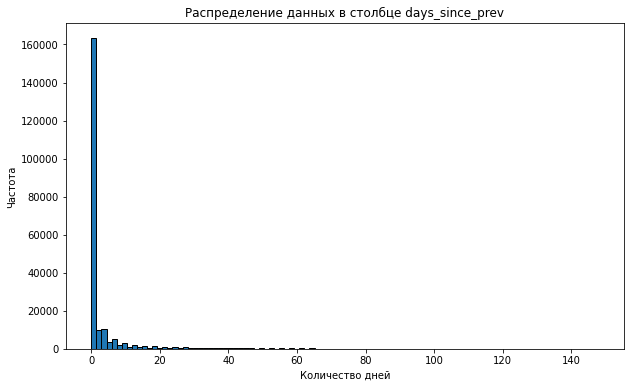

In [44]:
plt.figure(figsize=(10,6))

plt.hist(df[df['days_since_prev'].notna()]['days_since_prev'],bins=100,edgecolor='black')

plt.title('Распределение данных в столбце days_since_prev')
plt.xlabel('Количество дней')
plt.ylabel('Частота')

plt.show()

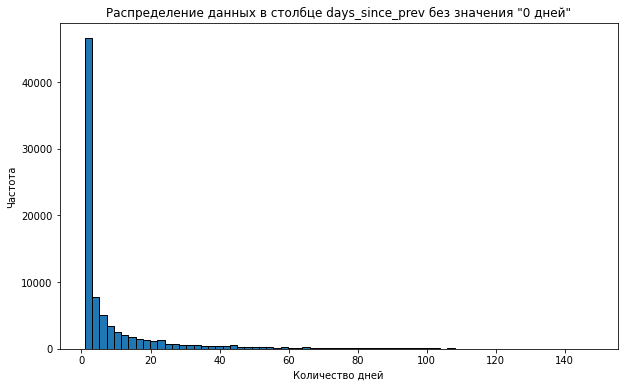

In [45]:
plt.figure(figsize=(10,6))

plt.hist(df[(df['days_since_prev'].notna())&(df['days_since_prev']>0)]['days_since_prev'],bins=70,edgecolor='black')

plt.title('Распределение данных в столбце days_since_prev без значения "0 дней"')
plt.xlabel('Количество дней')
plt.ylabel('Частота')

plt.show()

Из графиков выше видно, что распределение не нормальное, правоассиметричное, имеет длинный правый "хвост".

Уже начиная с 1 дня между заказами, частота резко снижается.

Диаграмма размаха:

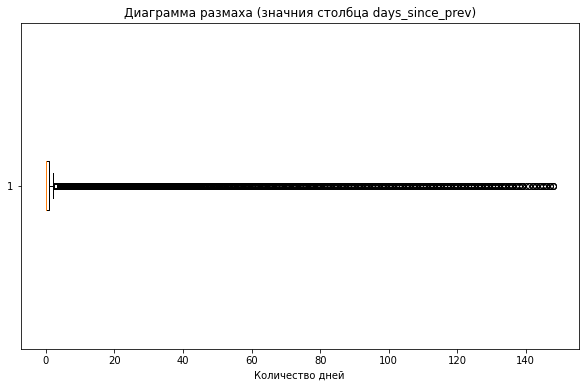

In [46]:
plt.figure(figsize=(10,6))

plt.boxplot(df[df['days_since_prev'].notna()]['days_since_prev'],vert=False)

plt.title('Диаграмма размаха (значния столбца days_since_prev)')
plt.xlabel('Количество дней')

plt.show()

Диаграмма размаха без отображения выбросов:

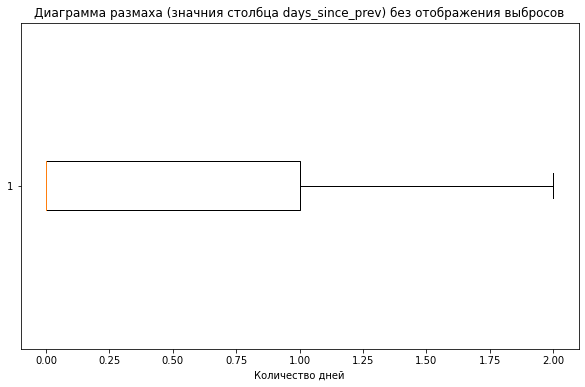

In [47]:
plt.figure(figsize=(10,6))

plt.boxplot(df[df['days_since_prev'].notna()]['days_since_prev'],vert=False,showfliers=False)

plt.title('Диаграмма размаха (значния столбца days_since_prev) без отображения выбросов')
plt.xlabel('Количество дней')

plt.show()

Диаграмма размаха не имеет правого "уса", поскольку первый квартиль совпадает со значением медианы. Значения более 2 дней исходя из критерия IQR между заказами считаются выбросами.

**Анализ значений столбца `tickets_count`:**

In [48]:
df['tickets_count'].describe()

count    239412.000000
mean          2.754745
std           1.173121
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

In [49]:
df['tickets_count'].mode()[0]

3

Значение среднего арифметического немного меньше, чем значение медианы - в среднем клиент за один заказ приобретает 3 билета. Значения моды и медианы равны.

Стандартное отклонение небольшое — большинство заказов близки к среднему.

Гистограмма распределения данных:

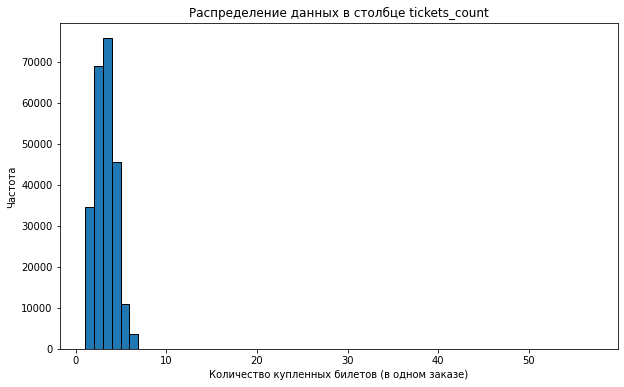

In [50]:
plt.figure(figsize=(10,6))

plt.hist(df['tickets_count'],bins=57,edgecolor='black')

plt.title('Распределение данных в столбце tickets_count')
plt.xlabel('Количество купленных билетов (в одном заказе)')
plt.ylabel('Частота')

plt.show()

Из графика выше следует, что распределение не нормальное, правоассиметричное, имеет правый "хвост". 
(хоть мода и медиана и больше среднего, что свидетельствует о левоассиметричном распределении, по графику видно, что это правоассиметричное распределение, имеющее длинный правый хвост)

Диаграмма размаха:

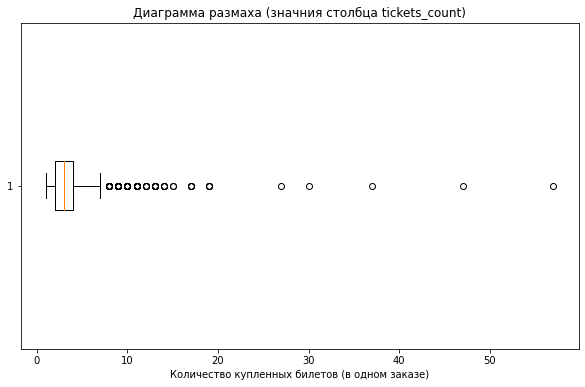

In [51]:
plt.figure(figsize=(10,6))

plt.boxplot(df['tickets_count'],vert=False)

plt.title('Диаграмма размаха (значния столбца tickets_count)')
plt.xlabel('Количество купленных билетов (в одном заказе)')

plt.show()

Диаграмма размаха без отображения выбросов:

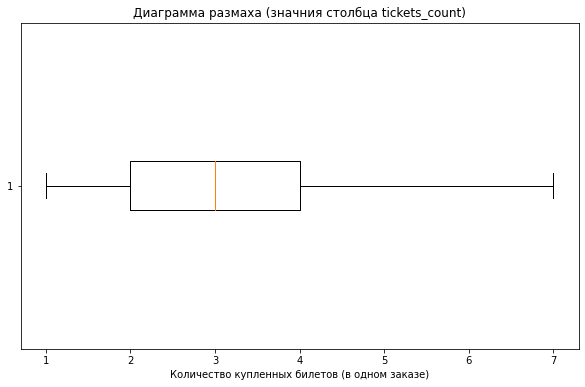

In [52]:
plt.figure(figsize=(10,6))

plt.boxplot(df['tickets_count'],vert=False,showfliers=False)

plt.title('Диаграмма размаха (значния столбца tickets_count)')
plt.xlabel('Количество купленных билетов (в одном заказе)')

plt.show()

Диаграмма размаха подтверждает, что распределение не является нормальным — оно скошено, с длинным хвостом вправо. 
Также на диаграмме хорошо визуализируются выбросы (значения более 7 билетов в одном заказе)

**Анализ значений столбца `revenue_rub`:**

In [53]:
df['revenue_rub'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    239412.000000
mean        567.101562
std         892.078674
min         -90.760002
25%         124.339996
50%         370.839996
75%         817.000000
95%        1630.650024
99%        2594.439941
max       81174.539062
Name: revenue_rub, dtype: float64

In [54]:
df['revenue_rub'].mode()[0]

0.0

Медиана меньше среднего арифметического значения, что свидетельствует от скошенности распределения. Имеются выбросы: максимальное значение в десятки раз больше, чем значение 99% процентиля.
Мода равна 0 (это может означать приобретение бесплатного билета, использование 100% скидки или подарочного сертификата, тестовый заказ). 

Минимальное значение отрицательное - вероятнее всего, это возвраты заказа (из описания проекта в Практикуме).

Количество и доля таких заказов с отрицательным значением в столбце `revenue_rub` (для таких заказов в базе данных значение столбца `total` (общая сумма заказа) из таблицы purchases схемы afisha также отрицательно):

In [55]:
ticket_refund = pd.Series({'Количество "возвратов"':df[df['revenue_rub'] < 0]['revenue_rub'].count(),
                                 'Доля "возвратов"':df[df['revenue_rub'] < 0]['revenue_rub'].count()/len(df),
                              'Процент "возвратов"':df[df['revenue_rub'] < 0]['revenue_rub'].count()/len(df) *100})
ticket_refund

Количество "возвратов"    327.000000
Доля "возвратов"            0.001366
Процент "возвратов"         0.136585
dtype: float64

Чтоьбы в дальнейшем при анализе профилей пользователей не завышать количество заказов на пользователя небходимо удалить из анализа данные с отрицательными значениями выручки. 
Доля удаления таких "возвратов" небольшая - будет убрано из анализа около 0.13% данных.

In [57]:
len_df = df.shape[0]

In [58]:
df = df[df['revenue_rub'] >= 0]

In [59]:
print(f'Количество строк в датафрейме до фильтрации: {len_df}')
print(f'Количество строк в датафрейме после фильтрации: {df.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': len_df - df.shape[0],
                         'Доля отфильтрованных строк:': (len_df - df.shape[0])/len_df,
                         'Процент отфильтрованных строк': (len_df - df.shape[0])/len_df * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 239412
Количество строк в датафрейме после фильтрации: 239085


Отфильтровано строк:             327.000000
Доля отфильтрованных строк:        0.001366
Процент отфильтрованных строк      0.136585
dtype: float64

В результате фильтрации из анализа убраны заказы, у которых имелись отрицательные значения выручки.

Гистограмма распределения данных:

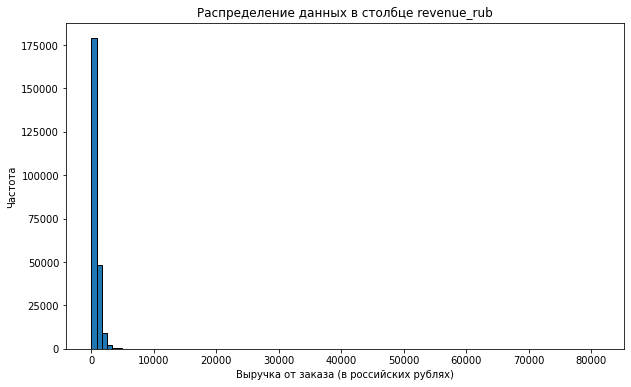

In [60]:
plt.figure(figsize=(10,6))

plt.hist(df['revenue_rub'],bins=100,edgecolor='black')

plt.title('Распределение данных в столбце revenue_rub')
plt.xlabel('Выручка от заказа (в российских рублях)')
plt.ylabel('Частота')

plt.show()

Из-за выбросов и большого максимального значения форма графика практически не видна. Следует только то, что распределение не нормальное, имеет длинный правый "хвост".

Гистограмма распределения данных, если данные отфильтровать и вывести значения ниже 99% процентиля.

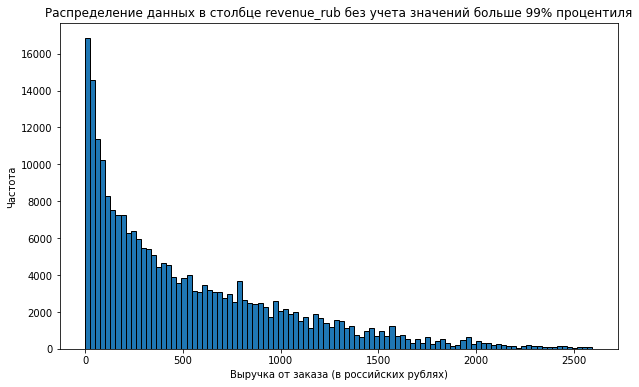

In [61]:
plt.figure(figsize=(10,6))

plt.hist(df[df['revenue_rub'] < df['revenue_rub'].quantile(0.99)]['revenue_rub'],bins=100,edgecolor='black')

plt.title('Распределение данных в столбце revenue_rub без учета значений больше 99% процентиля')
plt.xlabel('Выручка от заказа (в российских рублях)')
plt.ylabel('Частота')

plt.show()

Распределение скошено вправо, имеет длинный правый "хвост" (по мере роста значений выручки частота заказов постепенно падает)

Имеется пик вблизи нуля, что свидетельствует о большом количестве заказов с очень низкой выручкой.

Диаграмма размаха:

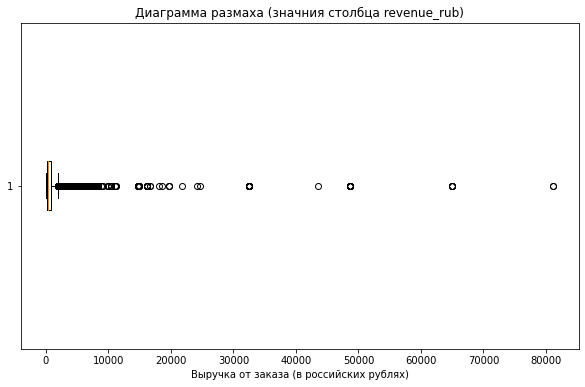

In [62]:
plt.figure(figsize=(10,6))

plt.boxplot(df['revenue_rub'],vert=False)

plt.title('Диаграмма размаха (значния столбца revenue_rub)')
plt.xlabel('Выручка от заказа (в российских рублях)')

plt.show()

Выбросы могут означать покупку большого количества билетов (например, корпоративная закупка, закупка билетов для школьников и т.п), либо покупку билетов в VIP-зоны, стоимость которых больше стоимости обычных билетов.

Диаграмма размаха без отображения выбросов:

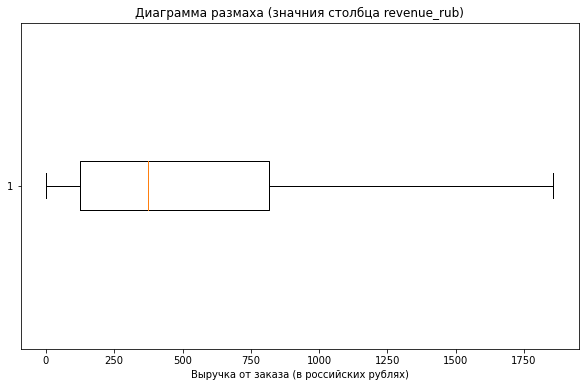

In [63]:
plt.figure(figsize=(10,6))

plt.boxplot(df['revenue_rub'],vert=False, showfliers=False)

plt.title('Диаграмма размаха (значния столбца revenue_rub)')
plt.xlabel('Выручка от заказа (в российских рублях)')

plt.show()

Диаграмма размаха подтверждает, что распределение не является нормальным — оно скошено вправо, правый "ус" длиннее левого.


Размер датафрейма до фильтрации:

In [64]:
len_df = df.shape[0]

Отфильтруем для дальнейшей работы выбросы по значениям в поле `revenue_rub`. Оставлю все строки датасета, у которых значения в поле `revenue_rub` меньше 99% процентиля.

In [65]:
df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)]

In [66]:
print(f'Количество строк в датафрейме до фильтрации: {len_df}')
print(f'Количество строк в датафрейме после фильтрации: {df.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': len_df - df.shape[0],
                         'Доля отфильтрованных строк:': (len_df - df.shape[0])/len_df,
                         'Процент отфильтрованных строк': (len_df - df.shape[0])/len_df * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 239085
Количество строк в датафрейме после фильтрации: 236700


Отфильтровано строк:             2385.000000
Доля отфильтрованных строк:         0.009976
Процент отфильтрованных строк       0.997553
dtype: float64

Обновлённые статистики:

In [67]:
df.describe()

,order_id,revenue,tickets_count,days_since_prev,event_id,revenue_rub
count,2.367000e+05,236700.000000,236700.000000,215033.000000,236700.000000,236700.000000
mean,4.321835e+06,569.865845,2.741724,3.982193,435323.645779,529.327087
std,2.496794e+06,723.153625,1.165397,12.497687,147120.734454,508.349396
min,1.000000e+00,0.000000,1.000000,0.000000,4436.000000,0.000000
25%,2.167483e+06,126.620003,2.000000,0.000000,356294.000000,123.269997
50%,4.313968e+06,369.910004,3.000000,0.000000,494529.000000,365.070007
75%,6.488323e+06,807.260010,3.000000,1.000000,543196.000000,802.030029
max,8.653108e+06,13784.259766,57.000000,148.000000,592325.000000,2594.439941


### Промежуточный вывод:

**Задача 2.1** :  
На основе данных о курсе тенге к российскому рублю из датафрейма <u>df_tenge</u> в датафрейме <u>df</u> создан дополнительный столбец `revenue_rub`. Он содержит нормализованные данные, приведенные к значениям выручки только в российских рублях.  
- `revenue_rub` - выручка от заказа (в российских рублях)  
- Тип данных: float32  
- Пропущенные значения: нет

**Задача 2.2** :  

- **Анализ дубликатов** в поле с уникальными значениями `order_id`. Дубликаты не обнаружены.  


- **Анализ неполных дубликатов** (полностью задублировавшиеся заказы, но с разными id заказа и временем заказа): обнаружено большое количество неполных дубликатов (51 199 строк, около 17% от всех данных). Эти заказы могут испортить статистики при последующем создании профиля пользователя, поэтому принято решение об их удалении.


- **Анализ пропусков:**

Тип пропусков в `days_since_prev` относятся к MAR. Пропуски появились при создании столбца `days_since_prev` при выгрузке из базы данных. Логика создания этого столбца предполагает наличие пропущенных значений: Nan указывает на то, что клиент покупал билеты только единожды.  
Из этого можно заключить, что всего 9% клиентов совершали только одну покупку, а оставшиеся 91% заказов совершались клиентами, у которых более одной покупки.  
Последующая обработка пропусков не проводилась, поскольку созданный столбец предполагает наличие значений Nan.

- **Типы данных:**

Изменен тип данных (float64 -> Int16) в столбце `days_since_prev`.  
Понижена размерность в столбцах: `tickets_count`, `event_id`, `order_id` (целочисленный тип данных); `revenue`, `revenue_rub` (вещественный тип данных)

- В ходе анализа **уникальных значений столбцов с номинальными данными** ошибок не выявлено. Нормализация данных не проводилась.

Данные представлены для заказов, сделанных с мобильных устройств и стационарных устройств.  
Заказы были оплачены двумя видами валют: тенге, российский рубль.  
Билеты приобретались на различные типы мероприятий: выставки, концерты, спорт, стендап, театр, ёлки, другое.  
Заказы совершались из большого числа различных регионов и городов.


- В ходе анализа ключевых **столбцов с числовыми значениями** было выявлено: 

Распределение значений во всех трех столбцах не нормальные, правоассиметричные, с правыми "хвостами". 

1. столбец `days_since_prev`  
В среднем между заказами проходит около 3 дней, но значение среднего арифметического (3.9 дня) и медианы значительно отличаются. Также и значение 75% процентиля (1 день) отлично от значения среднего, что свидетельствует от наличии больших значений, "тянущих" среднее арифметическое в сторону больших значений - это клиенты, которые возвращаются через большое количество дней и совершают повторные покупки билетов. Также эти клиенты влияют на стандартное отклонение: оно очень большое по сравнению со средним арифметическим - есть длинный "хвост".  
Максимальное количество дней между заказами: 148 дней, минимальное - 0 дней.  


2. столбец `tickets_count`  
Значение среднего арифметического немного меньше (2.75 шт.), чем значение медианы (3 шт.) - в среднем клиент за один заказ приобретает 3 билета. Значения моды и медианы равны. Стандартное отклонение небольшое, что свидетельствует о том, что большинство заказов близки к среднему.  
Максимальное количество билетов в заказе: 57, минимальное - 1.  
Значения более 7 билетов в одном заказе исходя из критерия IQR считаются выбросами. Выбросы могут означать покупку большого количества билетов в виду корпоративной закупки, закупки билетов для школьников/студентов и т.п.


3. столбец `revenue_rub`  
Медиана (370 руб.) меньше среднего арифметического значения (567 руб.). Имеются выбросы: максимальное значение (81 174 руб.) в десятки раз больше, чем значение 99% процентиля (2 594 руб.) . Мода равна 0 (это может означать приобретение бесплатного билета, использование 100% скидки или подарочного сертификата, тестовый заказ).
Минимальное значение отрицательное (- 90 руб.) - вероятнее всего, это возвраты заказа (из описания проекта в Практикуме).  
Выбросы могут означать покупку большого количества билетов (например, корпоративная закупка, закупка билетов для школьников и т.п), либо покупку билетов в VIP-зоны, стоимость которых больше стоимости обычных билетов.

**Предобработка данных:**  
- Удалены неполные дубликаты: 51 199 строк (17,6%)
- Удалены данные о заказах с отрицательными значениями выручки: 327 сток (0.13%)
- Были отфильтрованы данные по 99% процентилю значений столбца `revenue_rub` . В итоге отфильтровано 2385 строк, что составляет около 1% от всех данных.

Датафрейм <u>df</u> после фильтрации содержит 236 700 строк. (Размер датафрейма <u>df</u> до фильтрации 290 611 строк)

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.


**Задача 3.1.** Постройте профиль пользователя 

---


Сортирую датафрейм по времени совершения заказа:

In [68]:
df = df.sort_values(by=['user_id','order_ts'])

Проверка результата сортировки:

In [69]:
df[['user_id', 'order_ts']]

,user_id,order_ts
0,0002849b70a3ce2,2024-08-20 16:08:03
1,0005ca5e93f2cf4,2024-07-23 18:36:24
2,0005ca5e93f2cf4,2024-10-06 13:56:02
3,000898990054619,2024-07-13 19:40:48
4,000898990054619,2024-10-04 22:33:15
...,...,...
290606,fffcd3dde79eb2c,2024-10-27 17:53:53
290605,fffcd3dde79eb2c,2024-10-27 18:00:57
290608,fffcd3dde79eb2c,2024-10-30 13:37:43
290609,fffeeb3c120cf0b,2024-09-24 10:07:42


In [72]:
user_profile = df.groupby('user_id').agg(first_order=('order_dt', 'min'),
                                                last_order=('order_dt', 'max'), 
                                                device_type_f=('device_type_canonical', 'first'), 
                                                region_f=('region_name', 'first'),
                                                service_name_f=('service_name', 'first'), 
                                                event_type_f=('event_type_main', 'first'), 
                                                total_orders=('order_id', 'count'), 
                                                avg_revenue=('revenue_rub', 'mean'), 
                                                avg_tickets=('tickets_count', 'mean'),
                                                avg_time=('days_since_prev', 'mean'))

# Проверяю результат
user_profile.head(3)

,first_order,last_order,device_type_f,region_f,service_name_f,event_type_f,total_orders,avg_revenue,avg_tickets,avg_time
user_id,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,<NA>
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.0


Добавляю два дополнительных поля: `is_two` — совершил ли пользователь 2 и более заказа; `is_five` — совершил ли пользователь 5 и более заказов.

In [73]:
# Функция, для создания бинарного признака is_two
def create_is_two(x):
    if x >= 2:
        return 1
    else:
        return 0

# Функция, для создания бинарного признака is_five    
def create_is_five(x):
    if x >= 5:
        return 1
    else:
        return 0

# Применяем функции к столбцу total_orders
user_profile['is_two'] = user_profile['total_orders'].apply(create_is_two)
user_profile['is_five'] = user_profile['total_orders'].apply(create_is_five)

# Проверяю результат
user_profile.head()

,first_order,last_order,device_type_f,region_f,service_name_f,event_type_f,total_orders,avg_revenue,avg_tickets,avg_time,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,<NA>,0,0
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,75.0,1,0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213318,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,<NA>,0,0
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


При группировке user_id  стал индексом, поэтому использую метод reset_index и сделаю `user_id` обыкновенным столбцом:

In [74]:
user_profile = user_profile.reset_index()

# Проверяю результат
user_profile.columns

Index(['user_id', 'first_order', 'last_order', 'device_type_f', 'region_f',
       'service_name_f', 'event_type_f', 'total_orders', 'avg_revenue',
       'avg_tickets', 'avg_time', 'is_two', 'is_five'],
      dtype='object')

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [75]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21822 entries, 0 to 21821
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         21822 non-null  object        
 1   first_order     21822 non-null  datetime64[ns]
 2   last_order      21822 non-null  datetime64[ns]
 3   device_type_f   21822 non-null  object        
 4   region_f        21822 non-null  object        
 5   service_name_f  21822 non-null  object        
 6   event_type_f    21822 non-null  object        
 7   total_orders    21822 non-null  int64         
 8   avg_revenue     21822 non-null  float32       
 9   avg_tickets     21822 non-null  float64       
 10  avg_time        12966 non-null  Float64       
 11  is_two          21822 non-null  int64         
 12  is_five         21822 non-null  int64         
dtypes: Float64(1), datetime64[ns](2), float32(1), float64(1), int64(3), object(5)
memory usage: 2.1+ MB


Информация о пропусках:

In [76]:
missing_stats_user = pd.Series({'Кол-во пропусков': user_profile['avg_time'].isna().sum(),
                              'Доля пропусков': user_profile['avg_time'].isna().mean(),
                           'Процент пропусков': user_profile['avg_time'].isna().mean() * 100})

missing_stats_user

Кол-во пропусков     8856.000000
Доля пропусков          0.405829
Процент пропусков      40.582898
dtype: float64

Размер датафрейма с информацией о профиле пользователей содержит 21 822 строки и 13 столбцов.

Пропуски имеются только в столбце `avg_time` - около 40% от представленных данных. Пропуски в этом столбце означают то же самое, что и пропуски в столбце `days_since_prev`, на основе которого был сделан столбец `avg_time` - NA означает то, что клиент совершал только 1 заказ и дней между заказами у него вообще нет.

Объем используемой памяти 2.1+ MB. 

______

Количество уникальных пользователей будет равняться количеству строк датафрейма <u>user_profile</u>, поскольку для создания этого датафрейма использовалась группировка по столбцу `user_id`, то все значения этого поля уникальны.

Среднюю выручку с одного заказа можно рассчитать по формуле: 

    суммарная выручка от всех клиентов/ количество клиентов 
    
и сравнить получившееся значение с применением метода mean() (среднее от среднего, поскольку столбец `avg_revenue` хранит средние значения выручки за заказ)

In [77]:
print(f'Общее число пользователей в выборке: {user_profile.shape[0]} пользователей')
print(f'Средняя выручка с одного заказа (рассчитаное по формуле): {round(user_profile["avg_revenue"].sum()/user_profile.shape[0],2)} руб.')
print(f'Средняя выручка с одного заказа (среднее от среднего): {round(user_profile["avg_revenue"].mean(),2)} руб.')
print(f'Кол-во клиентов, совершивших 2 и более заказа: {user_profile["is_two"].sum()} пользователей. Доля: {round(user_profile["is_two"].mean(),2)}')
print(f'Кол-во клиентов, совершивших 5 и более заказов: {user_profile["is_five"].sum()} пользователей. Доля: {round(user_profile["is_five"].mean(),2)}')

Общее число пользователей в выборке: 21822 пользователей
Средняя выручка с одного заказа (рассчитаное по формуле): 542.52 руб.
Средняя выручка с одного заказа (среднее от среднего): 542.52 руб.
Кол-во клиентов, совершивших 2 и более заказа: 12932 пользователей. Доля: 0.59
Кол-во клиентов, совершивших 5 и более заказов: 5458 пользователей. Доля: 0.25


**Анализ значений в столбце `total_orders`:**

In [78]:
user_profile['total_orders'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    21822.000000
mean        10.846852
std        101.409647
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
95%         25.000000
99%        123.000000
max       8676.000000
Name: total_orders, dtype: float64

In [79]:
user_profile['total_orders'].mode()[0]

1

Среднее арифметическое сильно отличаеся от значения медианы, стандартное отклонение велико - это свидетельствует о наличии аномально больших значений (максимальное значение в 66 раз больше, чем значение 99% процентиля и в 328 раз больше, чем значение 95% процентиля). Мода меньше медианы и ее значение равняется минимальному значению, а также 25 % процентилю.
Распределение не нормальное, правоассиметричное, с длинным правым "хвостом".

Гистограмма распределения данных:

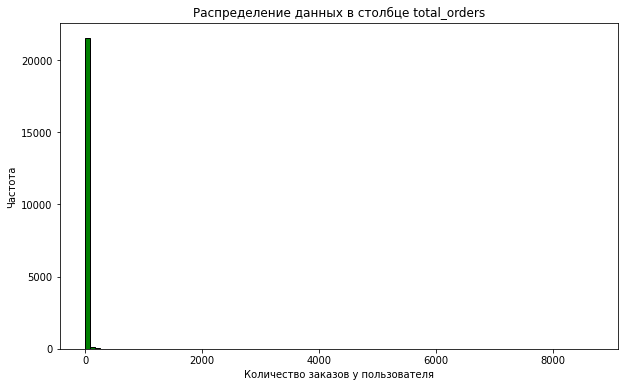

In [80]:
plt.figure(figsize=(10,6))

plt.hist(user_profile['total_orders'],bins=100,edgecolor='black',color='green')

plt.title('Распределение данных в столбце total_orders')
plt.xlabel('Количество заказов у пользователя')
plt.ylabel('Частота')

plt.show()

Гистограмма распределения данных с отфильтрованными значениями (отображение значений меньше 95% процентиля):

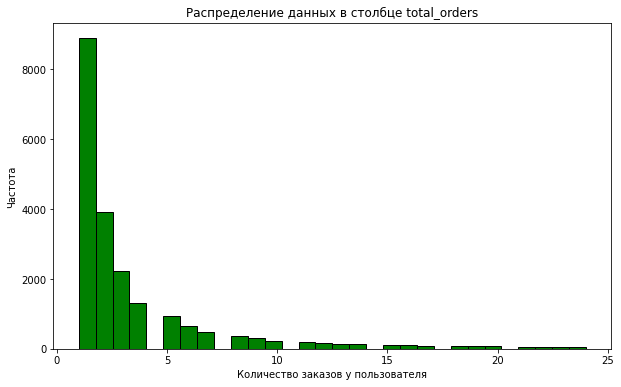

In [81]:
plt.figure(figsize=(10,6))

plt.hist(user_profile[user_profile['total_orders']<user_profile['total_orders'].quantile(0.95)]['total_orders'],bins=30,edgecolor='black',color='green')

plt.title('Распределение данных в столбце total_orders')
plt.xlabel('Количество заказов у пользователя')
plt.ylabel('Частота')

plt.show()

На графике сильно выделяются значения около 1, далее количество заказов у пользователей резко убывает.

Диаграмма размаха:

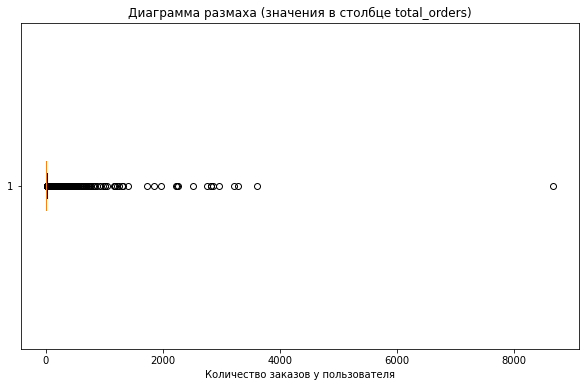

In [82]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['total_orders'], vert=False)

plt.title('Диаграмма размаха (значения в столбце total_orders)')
plt.xlabel('Количество заказов у пользователя')

plt.show()

Видно большое количество выбросов в широком диапазоне. "Ящик с усами" не визуализируется, если на графике отображены выбросы.

Диаграмма размаха без отображения выбросов:

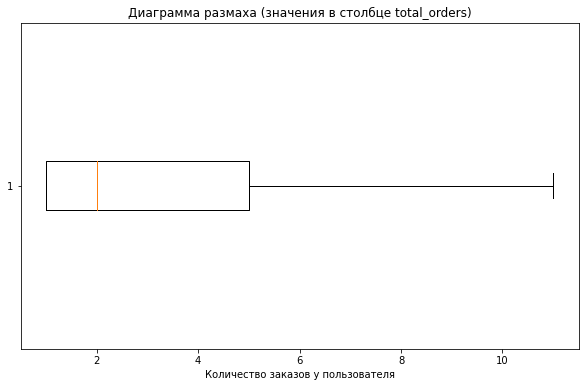

In [83]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['total_orders'], vert=False,showfliers=False)

plt.title('Диаграмма размаха (значения в столбце total_orders)')
plt.xlabel('Количество заказов у пользователя')

plt.show()

"Ящик" не имеет "левого" уса, поскольку минимальное значение совпадает со значением Q1(25% процентиль). Линия медианы смещена, на графике имеется только правый "ус", что подтверждает ассиметричность распределения и его скошенность.

Необходимо провести дальнейшую фильтрацию, но необходимо оценить количество данных, в которых значения в столбце total_orders больше 95% и 99% процентилей:

In [84]:
print(f'Количество строк со значениями > 95% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.95)].shape[0]}')
print(f'Доля строк со значениями > 95% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.95)].shape[0]/user_profile.shape[0]}')
print()
print(f'Количество строк со значениями > 99% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.99)].shape[0]}')
print(f'Доля строк со значениями > 99% процентиля: {user_profile[user_profile["total_orders"] >= user_profile["total_orders"].quantile(0.99)].shape[0]/user_profile.shape[0]}')

Количество строк со значениями > 95% процентиля: 1120
Доля строк со значениями > 95% процентиля: 0.051324351571808265

Количество строк со значениями > 99% процентиля: 221
Доля строк со значениями > 99% процентиля: 0.010127394372651453


Значение 95% процентиля отражает количество заказов у одного пользователя - около 31: столько заказов за период с июня по октябрь (5 месяцев) — это примерно 6 заказов в месяц. Для обычного активного пользователя это вполне реально, поэтому фильтрацию буду проводить по 95% процентилю.

**Анализ значений в столбце `avg_tickets`:**

In [85]:
user_profile['avg_tickets'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    21822.000000
mean         2.742974
std          0.907136
min          1.000000
25%          2.000000
50%          2.750000
75%          3.000000
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets, dtype: float64

In [86]:
user_profile['avg_tickets'].mode()[0]

3.0

Можно утверждать о том, что среднее арифметическое и медиана равны (различие в 0.01), что может свидетельствовать о симметричном распределении. Но при этом мода чуть больше, чем медиана.
Максимальное значение в 2 раза больше, чем значение 99% процентиля, что свидетельствует о наличии аномальных значений и появлении на графике правого "хвоста".

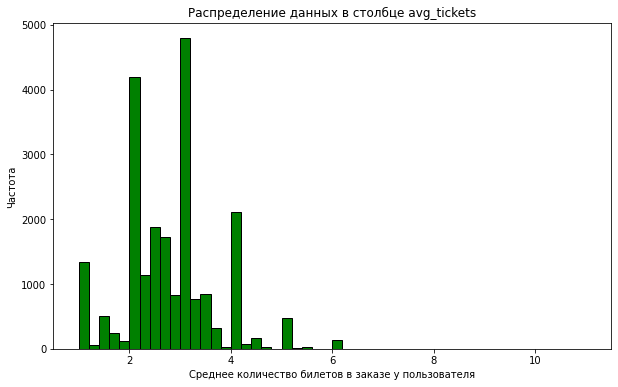

In [87]:
plt.figure(figsize=(10,6))

plt.hist(user_profile['avg_tickets'],bins=50,edgecolor='black',color='green')

plt.title('Распределение данных в столбце avg_tickets')
plt.xlabel('Среднее количество билетов в заказе у пользователя')
plt.ylabel('Частота')

plt.show()

Пики наблюдаются около значения 2 и около значения 3, что означает, что наиболее типичное поведение пользователя — покупать от 2 до 3 билетов за заказ.

Форма распределения — скошенная вправо. Большинство пользователей имеют значения в диапазоне 1–4 билета, а дальше представлены редкие случаи.

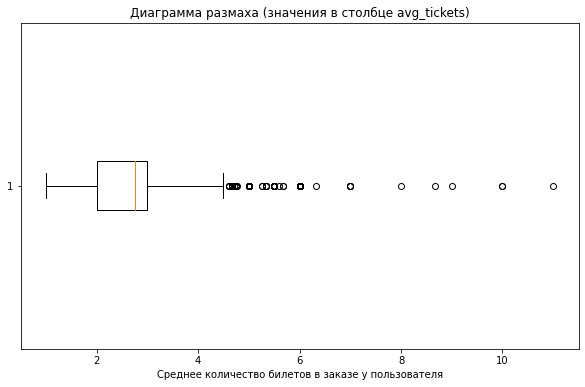

In [88]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['avg_tickets'], vert=False)

plt.title('Диаграмма размаха (значения в столбце avg_tickets)')
plt.xlabel('Среднее количество билетов в заказе у пользователя')

plt.show()

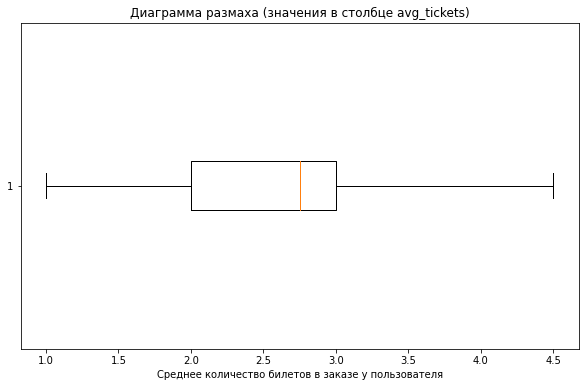

In [89]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile['avg_tickets'], vert=False,showfliers=False)

plt.title('Диаграмма размаха (значения в столбце avg_tickets)')
plt.xlabel('Среднее количество билетов в заказе у пользователя')

plt.show()

Левый "ус" короче правого, что подтверждает ассиметричность распределения и наличие правого "хвоста", состоящего из выбросов.

Оценка количества данных, в которых значения в столбце avg_tickets больше 95% и 99% процентилей:

In [90]:
print(f'Количество строк со значениями > 95% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.95)].shape[0]}')
print(f'Доля строк со значениями > 95% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.95)].shape[0]/user_profile.shape[0]}')
print()
print(f'Количество строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]}')
print(f'Доля строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]/user_profile.shape[0]}')

Количество строк со значениями > 95% процентиля: 3025
Доля строк со значениями > 95% процентиля: 0.13862157455778573

Количество строк со значениями > 99% процентиля: 660
Доля строк со значениями > 99% процентиля: 0.030244707176244157


**Анализ значений в столбце `avg_time`:**

In [91]:
user_profile['avg_time'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    12966.000000
mean        18.219059
std         23.379191
min          0.000000
25%          2.274876
50%         10.428571
75%         24.191667
95%         66.000000
99%        116.350000
max        148.000000
Name: avg_time, dtype: float64

In [92]:
user_profile['avg_time'].mode()[0]

0.0

Значения среднего арифметического и медианы сильно отличаются, значение стандартного отклонения велико (больше среднего арифметического). Мода совпадает с минимальным значением (0 дней между заказами).  
Минимальное значение - 0 дней между заказами, максимальное - 148 дней между заказами. Имеются большие значения, которые создают правый "хвост".

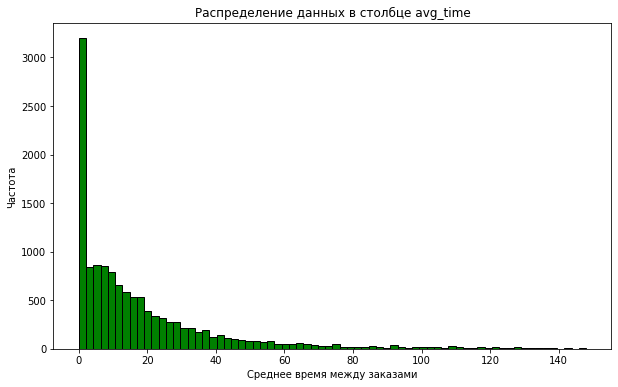

In [93]:
plt.figure(figsize=(10,6))

plt.hist(user_profile[user_profile['avg_time'].notna()]['avg_time'],bins=70,edgecolor='black',color='green')

plt.title('Распределение данных в столбце avg_time')
plt.xlabel('Среднее время между заказами')
plt.ylabel('Частота')

plt.show()

Распределение не нормальное, скошенное вправо, имеет "хвост". Также на графике визуализируется пик около значения 0, отчетливо визуализирующий значение моды и то, сколько раз такое значение встречается.

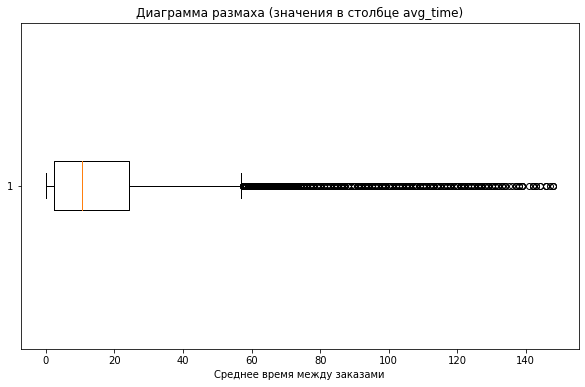

In [94]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile[user_profile['avg_time'].notna()]['avg_time'], vert=False)

plt.title('Диаграмма размаха (значения в столбце avg_time)')
plt.xlabel('Среднее время между заказами')

plt.show()

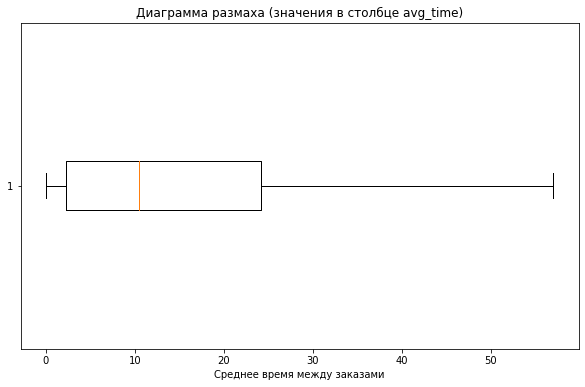

In [95]:
plt.figure(figsize=(10,6))

plt.boxplot(user_profile[user_profile['avg_time'].notna()]['avg_time'], vert=False,showfliers=False)

plt.title('Диаграмма размаха (значения в столбце avg_time)')
plt.xlabel('Среднее время между заказами')

plt.show()

Распределение асимметричное, скошенное вправо. Это также видно на диаграмме размаха, где левый "ус" намного короче "правого". Значение медианы также сдвинуто, оно находится не в середине "ящика". 

_____

Фильтрация данных (по значению 95% процентиля столбца total_orders):

In [96]:
# Длина датафрейма до фильтрации
initial_len_user_profile = user_profile.shape[0]

user_profile = user_profile[user_profile["total_orders"] <= user_profile["total_orders"].quantile(0.95)]

In [97]:
print(f'Количество строк в датафрейме до фильтрации: {initial_len_user_profile}')
print(f'Количество строк в датафрейме после фильтрации: {user_profile.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': initial_len_user_profile - user_profile.shape[0],
                         'Доля отфильтрованных строк:': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile,
                         'Процент отфильтрованных строк': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 21822
Количество строк в датафрейме после фильтрации: 20739


Отфильтровано строк:             1083.000000
Доля отфильтрованных строк:         0.049629
Процент отфильтрованных строк       4.962881
dtype: float64

После фильтрации проверка распределения значений в столбце avg_tickets:

In [98]:
user_profile['avg_tickets'].describe(percentiles=[0.25,0.50,0.75,0.95,0.99])

count    20739.000000
mean         2.743753
std          0.928919
min          1.000000
25%          2.000000
50%          2.750000
75%          3.111111
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets, dtype: float64

Максимальное значение среднего количества билетов в заказе - 11 билетов - свидетельствует о сегменте пользователей, которые совершали корпоративные и прочие закупки, которые характеризуются покупкой билетов на большое количество человек.  
После фильтрациии датафрейма с профилями пользователей по общему количеству заказов такие "корпоративные" клиенты остались, поэтому далее необходимо провести фильтрацию по значению 99% процентиля столбца avg_tickets:

Предварительно оцениваю количество строк, которые могут быть отфильтрованы:

In [99]:
print(f'Количество строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]}')
print(f'Доля строк со значениями > 99% процентиля: {user_profile[user_profile["avg_tickets"] >= user_profile["avg_tickets"].quantile(0.99)].shape[0]/user_profile.shape[0]}')

Количество строк со значениями > 99% процентиля: 660
Доля строк со значениями > 99% процентиля: 0.03182409952263851


Провожу фильтрацию по значению 99% процентиля столбца avg_tickets:

In [100]:
# Промежуточный размер датафрейма (после первой фильтрации, до второй фильтрации)
len_user_profile = user_profile.shape[0]

user_profile = user_profile[user_profile['avg_tickets'] <= user_profile['avg_tickets'].quantile(0.99)]

In [101]:
print(f'Количество строк в датафрейме до фильтрации: {len_user_profile}')
print(f'Количество строк в датафрейме после фильтрации: {user_profile.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': len_user_profile - user_profile.shape[0],
                         'Доля отфильтрованных строк:': (len_user_profile - user_profile.shape[0])/len_user_profile,
                         'Процент отфильтрованных строк': (len_user_profile - user_profile.shape[0])/len_user_profile * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 20739
Количество строк в датафрейме после фильтрации: 20560


Отфильтровано строк:             179.000000
Доля отфильтрованных строк:        0.008631
Процент отфильтрованных строк      0.863108
dtype: float64

Итого после фильтрации по двум полям:

In [102]:
print(f'Количество строк в датафрейме до фильтрации: {initial_len_user_profile}')
print(f'Количество строк в датафрейме после фильтрации: {user_profile.shape[0]}')

row_filtered = pd.Series({'Отфильтровано строк:': initial_len_user_profile - user_profile.shape[0],
                         'Доля отфильтрованных строк:': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile,
                         'Процент отфильтрованных строк': (initial_len_user_profile - user_profile.shape[0])/initial_len_user_profile * 100})

row_filtered

Количество строк в датафрейме до фильтрации: 21822
Количество строк в датафрейме после фильтрации: 20560


Отфильтровано строк:             1262.000000
Доля отфильтрованных строк:         0.057832
Процент отфильтрованных строк       5.783155
dtype: float64

После фильтрации информация по следующим показателям обновлена:

In [103]:
print(f'Общее число пользователей в выборке: {user_profile.shape[0]} пользователей')
print(f'Средняя выручка с одного заказа (рассчитаное по формуле): {round(user_profile["avg_revenue"].sum()/user_profile.shape[0],2)} руб.')
print(f'Средняя выручка с одного заказа (среднее от среднего): {round(user_profile["avg_revenue"].mean(),2)} руб.')
print(f'Кол-во клиентов, совершивших 2 и более заказа: {user_profile["is_two"].sum()} пользователей. Доля: {round(user_profile["is_two"].mean(),2)}')
print(f'Кол-во клиентов, совершивших 5 и более заказов: {user_profile["is_five"].sum()} пользователей. Доля: {round(user_profile["is_five"].mean(),2)}')

Общее число пользователей в выборке: 20560 пользователей
Средняя выручка с одного заказа (рассчитаное по формуле): 541.67 руб.
Средняя выручка с одного заказа (среднее от среднего): 541.67 руб.
Кол-во клиентов, совершивших 2 и более заказа: 11806 пользователей. Доля: 0.57
Кол-во клиентов, совершивших 5 и более заказов: 4374 пользователей. Доля: 0.21


Статистики после фильтрации: 

In [104]:
for col in ['total_orders','avg_tickets','avg_time']:
    print(user_profile[col].describe())

count    20560.000000
mean         3.444358
std          4.097280
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         25.000000
Name: total_orders, dtype: float64
count    20560.000000
mean         2.715001
std          0.877639
min          1.000000
25%          2.000000
50%          2.750000
75%          3.000000
max          5.000000
Name: avg_tickets, dtype: float64
count    11839.000000
mean        19.664770
std         23.929630
min          0.000000
25%          3.000000
50%         12.111111
75%         26.333333
max        148.000000
Name: avg_time, dtype: float64


Вид гистограмм распределения после фильтрации:

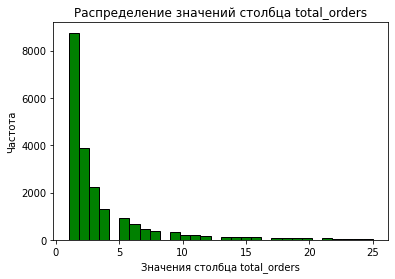

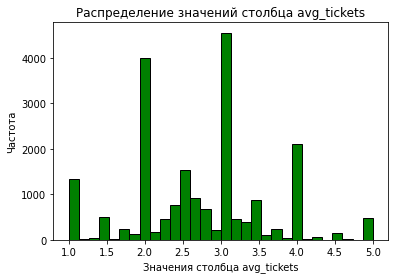

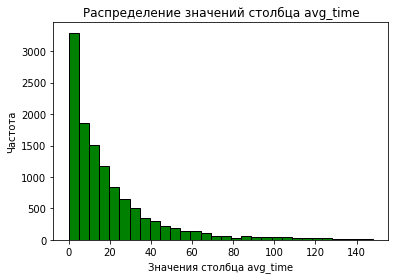

In [105]:
for col in ['total_orders','avg_tickets','avg_time']:
    plt.hist(user_profile[user_profile[col].notna()][col],bins=30,edgecolor='black',color='green')
    plt.title(f'Распределение значений столбца {col}')
    plt.xlabel(f'Значения столбца {col}')
    plt.ylabel('Частота')
    plt.show()

Вид диаграмм разброса после фильтрации:

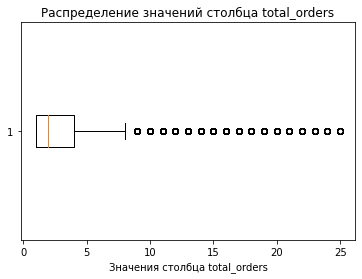

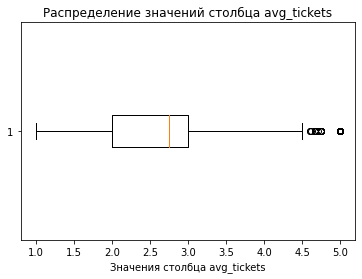

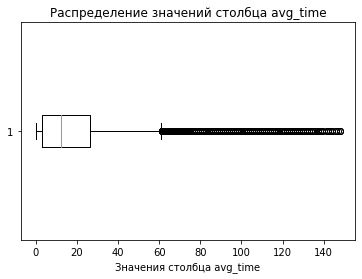

In [106]:
for col in ['total_orders','avg_tickets','avg_time']:
    plt.boxplot(user_profile[user_profile[col].notna()][col],vert=False)
    plt.title(f'Распределение значений столбца {col}')
    plt.xlabel(f'Значения столбца {col}')
    plt.show()

После фильтрации значения в столбце `total_orders` распределены следующим образом: среднее арифметическое в два раза больше значения медианы, стандартное отклонение велико и его значение больше среднего арифметического. Распределение не нормальное. Минимальное значение осталось таким же, максимальное "сдвинулось влево" и теперь равно 31 заказу у пользователя.  
Значения в столбце `avg_tickets` распределены: среднее арифметическое и медиана имеют теперь немного большее различие, чем до фильтрации, но эти различия всё ещё заключаются в нескольких сотых значения. Максимальное значение теперь также "сдвинуто влево" и равно 5 билетам в одном заказе. Гистограмма распределения стала визуально более симметричной, если исключить пики около некоторых значений из визуального анализа.
Значения в столбце `avg_time` также изменились: значение среднего и медианы "выросли" приблизительно на 1.5, максимальное количество дней между заказами осталось прежним.

### Промежуточный вывод:

**Задача 3.1: Создание профиля пользователя** 

На основе информации в датафрейме <u>df</u> построена сводная таблица с агрегированными данными (профиль пользователя) <u>user_profile</u> .  
Описание столбцов:   
`user_id` - id пользователя;  
`first_order` - дата первого заказа;   
`last_order` - дата последнего заказа;  
`device_type_f` - устройство, с которого был сделан первый заказ;  
`region_f` - регион мероприятия, в котором был сделан первый заказ;  
`service_name_f` - билетный партнёр, к которому обращались при первом заказе;  
`event_type_f` - жанр первого посещённого мероприятия;  
`total_orders` - общее количество заказов;  
`avg_revenue` - средняя выручка с одного заказа (в рублях);  
`avg_tickets` - среднее количество билетов в заказе;  
`avg_time` - среднее время между заказами.  
  
А также два дополнительных поля:  
`is_two` - совершил ли пользователь 2 и более заказа;  
`is_five` - совершил ли пользователь 5 и более заказов.  

Размер датафрейма с информацией о профиле пользователей содержит 21 822 строк и 13 столбцов.  
Пропуски имеются только в столбце `avg_time` - около 40% от представленных данных. Пропуски в этом столбце означают то, что клиент совершал только 1 заказ и дней между заказами у него вообще нет.  
Объем используемой памяти 2.1+ MB. 

**Задача 3.2: Анализ данных в профиле пользователя** 

Общее число пользователей в выборке - 21 822 пользователя, средняя выручка с одного заказа - 542 руб., процент пользователей, совершивших 2 и более заказа - 59% , процент пользователей, совершивших 5 и более заказов - 25% .

Изучены статистические показатели:

- `total_orders`  
Среднее арифметическое (10.84) сильно отличаеся от значения медианы (2), стандартное отклонение велико (101.41)- это свидетельствует о наличии аномально больших значений (максимальное значение в 66 раз больше, чем значение 99% процентиля и в 328 раз больше, чем значение 95% процентиля). Мода (1) меньше медианы (2) и ее значение равняется минимальному значению, а также 25 % процентилю. Распределение не нормальное, правоассиметричное, с длинным правым "хвостом".  
Значение 95% процентиля отражает количество заказов у одного пользователя - около 25: столько заказов за период с июня по октябрь (5 месяцев) — это примерно 5 заказов в месяц. Для обычного активного пользователя это вполне реально, поэтому дальнейшая фильтрация будет проводиться по 95% процентилю.

- `avg_tickets`  
Среднее арифметическое (2.74) и медиана (2.75) равны, что может свидетельствовать о симметричном распределении. Но при этом мода (3) чуть больше, чем медиана. Максимальное значение в 2 раза больше, чем значение 99% процентиля, что свидетельствует о наличии аномальных значений и появлении на графике правого "хвоста".
Максимальное значение среднего количества билетов в заказе - 11 билетов - свидетельствует о сегменте пользователей, которые совершали корпоративные и прочие закупки, которые характеризуются покупкой билетов на большое количество человек. Будет проводиться дальнейшая фильтрация по значению 99% процентиля этого столбца.

- `avg_time`  
Значения среднего арифметического (18.21) и медианы (10.42) сильно отличаются, значение стандартного отклонения велико (22.3, больше среднего арифметического). Мода совпадает с минимальным значением (0 дней между заказами).  
Минимальное значение - 0 дней между заказами, максимальное - 148 дней между заказами. Имеются большие значения, которые создают правый "хвост". Распределение не нормальное, правоассиметричное, с правым "хвостом".  

Проведена фильтрация по 95% процентилю значений столбца `total_orders` и последующая фильтрация по 99% процентилю значений столбца `avg_tickets`.
В ходе фильтрации отфильтровано (удалено из анализа) 1262 строк, что составляет менее 6% данных. 

После фильтрации: общее число пользователей в выборке - 20 560 пользователей (*-1262 пользователя*), средняя выручка с одного заказа - 541 руб.(*-1 руб.*), процент пользователей, совершивших 2 и более заказа - 57% (*-2%*) , процент пользователей, совершивших 5 и более заказов - 21% (*-4%*) .

Статистические показатели после фильтрации по обновлённому датасету:

- `total_orders`  
Среднее арифметическое (3.44) больше значения медианы (2), стандартное отклонение велико (4.09) и его значение больше среднего арифметического. Но эти различия стали меньше по сравнению с тем, что было до фильтрации. Распределение не нормальное. Минимальное значение осталось таким же, максимальное "сдвинулось влево" (25)

- `avg_tickets`  
Среднее арифметическое (2.71) и медиана (2.75) имеют теперь немного большее различие, чем до фильтрации, но эти различия всё ещё заключаются в нескольких сотых значения. Максимальное значение (5) теперь также "сдвинуто влево". Гистограмма распределения стала визуально более симметричной, если исключить пики около некоторых значений из визуального анализа.

- `avg_time`  
Значение среднего (19.66) и медианы (12.11) "выросли", максимальное количество дней между заказами осталось прежним.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** 

---


Задаю функцию, которая будет выводить информацию о сегментах пользователей:

In [107]:
# Функция, выводящая информацию о заданном сегменте пользователей
def segmentation(series):
    print (pd.DataFrame({'Количество пользователей:':series.value_counts(),
                             'Доля пользователей:':series.value_counts(normalize=True)}))

Сегментация пользователей (**по типу их первого мероприятия**):

In [108]:
segmentation(user_profile['event_type_f'])

          Количество пользователей:  Доля пользователей:
концерты                       9124             0.443774
другое                         5081             0.247130
театр                          4035             0.196255
стендап                        1061             0.051605
спорт                           764             0.037160
выставки                        401             0.019504
ёлки                             94             0.004572


Концерты — главная "точка входа". Почти половина пользователей (44%) впервые пришли через концерт. Категория "другое" нуждается в расшифровке (это могут быть лекции, фестивали, что-то ещё). Почти 25 % пользователей — это театральные зрители.  
Ёлки - сезонный сегмент, поэтому в нем так мало пользователей. Ведь данные представлены за летние месяцы и два первых осенних месяца. Возможно, этот сегмент здесь появился потому, что пользователи заранее в октябре приобрели билеты.

Сегментация пользователей (**по типу устройства, с которого совершена первая покупка**):

In [109]:
segmentation(user_profile['device_type_f'])

         Количество пользователей:  Доля пользователей:
mobile                       17058             0.829669
desktop                       3502             0.170331


В сегменте по типу устройства, с которого совершена первая покупка, количество пользователей и их доля распределены не равномерно: около 83% пользователей сделали свой заказ с мобильного телефона (это выраженная "точка входа"). Оставшиеся 17% пользователей сделали свой первый заказ со стационарного устройства.

Сегментация пользователей (**по региону проведения мероприятия из первого заказа**):

In [110]:
segmentation(user_profile['region_f'])

                          Количество пользователей:  Доля пользователей:
Каменевский регион                             6730             0.327335
Североярская область                           3559             0.173103
Широковская область                            1173             0.057053
Озернинский край                                658             0.032004
Малиновоярский округ                            512             0.024903
...                                             ...                  ...
Тихогорская область                               2             0.000097
Яснопольский округ                                1             0.000049
Сосноводолинская область                          1             0.000049
Светолесский край                                 1             0.000049
Верхозёрский край                                 1             0.000049

[81 rows x 2 columns]


Сегменты пользователей по регионам распределены также неравномерно: в Каменевском регионе на первое мероприятие приобрели билеты треть всех пользователей (32%), 17% пользователей приходится на Североярскую область. Оставшийся 51% неравномерно распределен по 79 регионам (Широковская область - 5% пользователей, Озернинский край - 3% пользователей, и так далее до тысячных долей процента). 

Сегментация пользователей (**по билетному оператору, продавшему билеты на первый заказ**):

In [111]:
segmentation(user_profile['service_name_f'])

                        Количество пользователей:  Доля пользователей:
Билеты без проблем                           4886             0.237646
Мой билет                                    2812             0.136770
Лови билет!                                  2690             0.130837
Билеты в руки                                2417             0.117558
Облачко                                      2101             0.102189
Весь в билетах                               1226             0.059630
Лучшие билеты                                1119             0.054426
Прачечная                                     549             0.026702
Край билетов                                  435             0.021158
Дом культуры                                  335             0.016294
Яблоко                                        307             0.014932
Тебе билет!                                   294             0.014300
Городской дом культуры                        205             0.009971
Мир ка

Данные в этом сегменте распределены также неравномерно: выделяется билетный оператор "Билеты без проблем", продавший билеты на первый заказ около 24% пользователям. Далее за ним следуют операторы "Мой билет", "Лови билет",  "Билеты в руки", "Облачко" - от 10% до 14% пользователям они продали билеты на первый заказ. Далее для остальных сервисов проценты пользователей в сегментах варьируются от 5% до тысячных долей процента. 

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:


---


Сегмент пользователей **по типу их первого мероприятия**, совершившие 2 и более заказа:

In [112]:
user_profile.groupby('event_type_f')['is_two'].mean().sort_values(ascending=False)

event_type_f
выставки    0.610973
театр       0.597274
концерты    0.575844
стендап     0.574929
другое      0.558551
ёлки        0.553191
спорт       0.519634
Name: is_two, dtype: float64

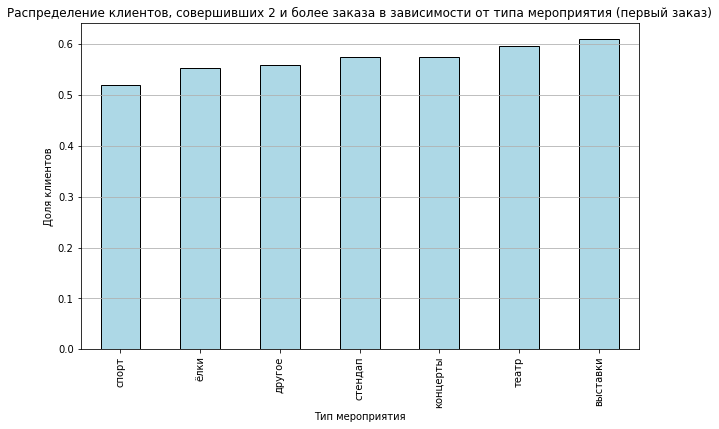

In [113]:
plt.figure(figsize=(10,6))

user_profile.groupby('event_type_f')['is_two'].mean().sort_values().plot(kind='bar',color='lightblue',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от типа мероприятия (первый заказ)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля клиентов')
plt.grid(axis='y')

plt.show()

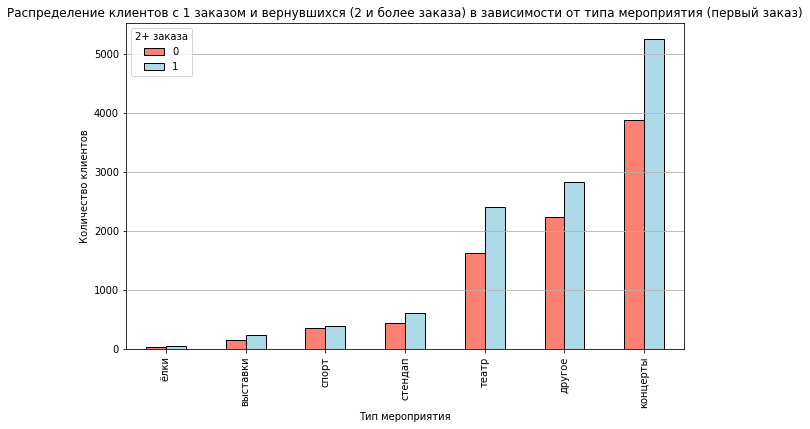

In [114]:
user_profile.groupby('event_type_f')['is_two'].value_counts().unstack(fill_value=0).sort_values(by=1).plot(kind='bar', figsize=(10,6),color=['salmon', 'lightblue'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от типа мероприятия (первый заказ)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Количество клиентов')
plt.grid(axis='y')
plt.legend(title='2+ заказа')

plt.show()

Примерно 61% пользователей совершают повторные заказы, если их первые приобретенные билеты на мероприятия типов "выставки", 60% - "театр". 58% пользователей возвращаются повторно после приобретения билетов на "концерты" и "стендап". Но учитывая размер выборок (клиентов, заказавших билеты впервые на концерты и театр, больше, чем пользователей в других типах мероприятий), можно говорить о том, что значимые проценты пользователей с повторными заказами у типов - "концерт" и "театр".   
Меньше всего совершают повторные покупки пользователи, у которых тип первого мероприятия был "спорт" (около 52%), "елки" (около 55%) и категория "другое" (около 56%)

Более 5 тыс. пользователей вернулись на Яндекс Афишу после приобретенных впервые билетов на концерты. Около 2,5 тыс. и 3 тыс. вернувшихся пользователей для типов первого мероприятия "театр" и "другое".

Сегмент пользователей **по типу устройства, с которого совершена первая покупка**, совершившие 2 и более заказа:

In [115]:
user_profile.groupby('device_type_f')['is_two'].mean()

device_type_f
desktop    0.601085
mobile     0.568707
Name: is_two, dtype: float64

Среди пользователей, совершивших первый заказ с мобильного устройства, около 57% совершили 2 и более заказа. Около 60% пользователей, совершивших первый заказ со стационарного устройства, сделали 2 и более заказа.  

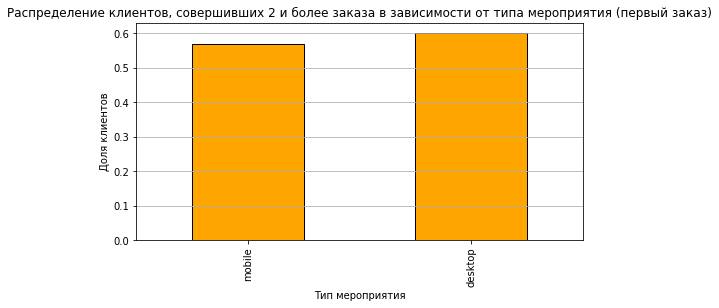

In [116]:
plt.figure(figsize=(8,4))

user_profile.groupby('device_type_f')['is_two'].mean().sort_values().plot(kind='bar',color='orange',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от типа мероприятия (первый заказ)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля клиентов')
plt.grid(axis='y')

plt.show()

Поскольку основная масса пользователей совершала свой первый заказ с мобильного устройства, но доли повторно возвращающихся пользователей примерно одинаковы для двух видов устройств, имеет смысл отобразить на графике и процент пользователей, которые сделали всего 1 заказ: 

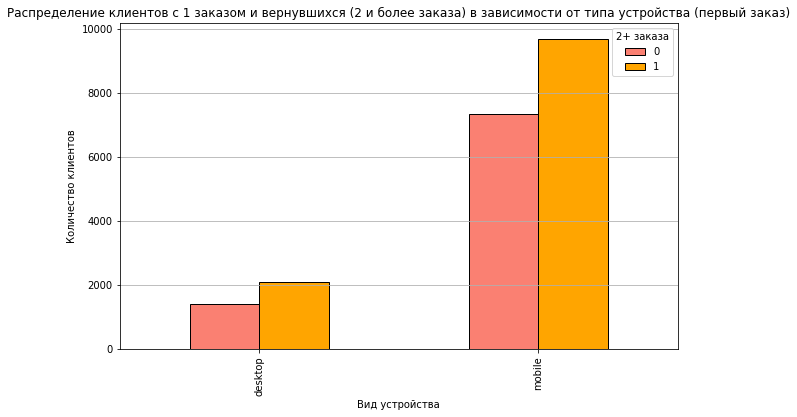

In [117]:
user_profile.groupby('device_type_f')['is_two'].value_counts().unstack(fill_value=0).plot(kind='bar',figsize=(10,6),color=['salmon', 'orange'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от типа устройства (первый заказ)')
plt.xlabel('Вид устройства')
plt.ylabel('Количество клиентов')
plt.grid(axis='y')
plt.legend(title='2+ заказа')

plt.show()

Около 10 тыс. пользователей сделали 2 и более заказа, когда тип устройства при их первом заказе было мобильное устройство. И более 2 тыс. пользователей сделали 2 и болеее заказа, при использовании в первом заказе стационарного устройства. 
Но при этом, если сравнивать доли, то доля возвращающихся повторно клиентов будет на 3% больше для стационарного устройства, нежели для мобильного.
Соответственно, тип используемого при первом заказе устройства особого влияния на повтор заказа в будущем не оказывает. 

Сегмент пользователей **по региону проведения мероприятия из первого заказа**, совершившие 2 и более заказа:

In [118]:
# Определяю топ-10 регионов по количеству пользователей
top_regions = user_profile['region_f'].value_counts().head(10).index

# Вывод количества пользователей, совершивших повторные заказы, по регионам
user_profile[user_profile['region_f'].isin(top_regions)].groupby('region_f')['is_two'].mean().sort_values(ascending=False)

region_f
Светополянский округ    0.616628
Широковская область     0.610401
Шанырский регион        0.609071
Североярская область    0.600450
Речиновская область     0.589928
Каменевский регион      0.587370
Травяная область        0.577253
Яблоневская область     0.568182
Малиновоярский округ    0.525391
Озернинский край        0.507599
Name: is_two, dtype: float64

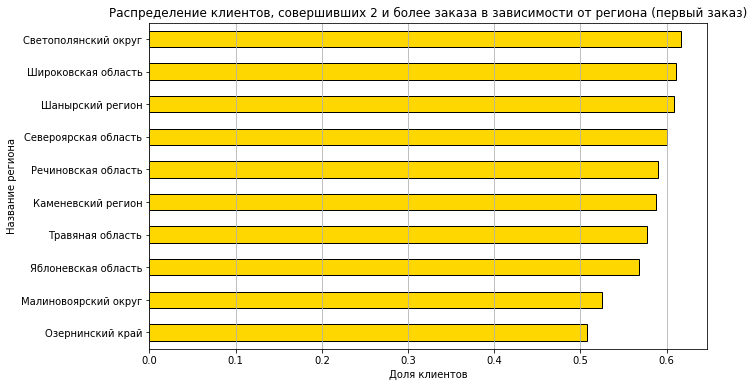

In [119]:
plt.figure(figsize=(10,6))

user_profile[user_profile['region_f'].isin(top_regions)].groupby('region_f')['is_two'].mean().sort_values(ascending=True).plot(kind='barh',color='gold',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от региона (первый заказ)')
plt.xlabel('Доля клиентов')
plt.ylabel('Название региона')
plt.grid(axis='x')

plt.show()

Среди клиентов, совершивших 2 и более заказа, распределение по регионам достаточно равномерное — доли повторных покупателей в каждом регионе близки друг к другу, без выраженных резких перепадов. Это говорит о том, что лояльные клиенты присутствуют во всех регионах, и повторные покупки не сконцентрированы в каком-то одном географическом сегменте.
Лидирующими регионами по проценту возврата являются: Светополянский округ, Широковская область и Шанырский регион (около 61%). Самые низкие проценты возврата у Малиновоярского округа и Озернинского края (около 50-52%)

Поскольку регионы (первая покупка) представлены различным количеством клиентов, необходимо построить следующую визуализацию:

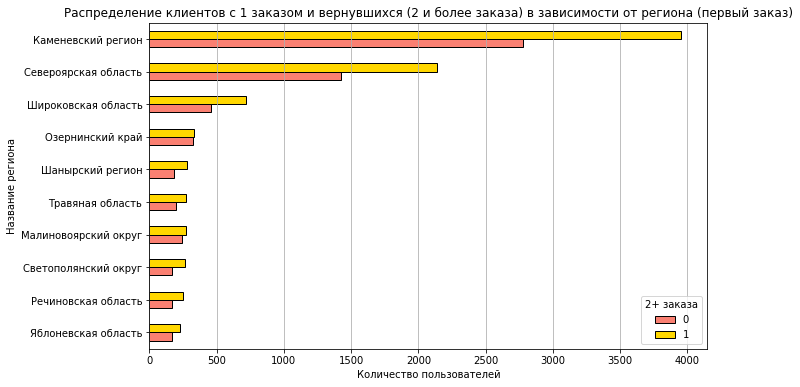

In [120]:
user_profile[user_profile['region_f'].isin(top_regions)].groupby('region_f')['is_two'].value_counts().unstack(fill_value=0).sort_values(by=1).plot(kind='barh',figsize=(10,6),color=['salmon', 'gold'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от региона (первый заказ)')
plt.xlabel('Количество пользователей')
plt.ylabel('Название региона')
plt.grid(axis='x')
plt.legend(title='2+ заказа')

plt.show()

Распределение количества пользователей по регионам остаётся неравномерным: Каменевский регион лидирует по общему числу клиентов, включая тех, кто совершил повторные покупки. Однако доля возврата (соотношение между пользователями с одним заказом и с 2+ заказами) варьируется между регионами. Некоторые регионы, несмотря на умеренное общее количество клиентов, демонстрируют высокую долю возврата — например, Шанырский и Светополянский округа. Получается, что лояльность клиентов не всегда коррелирует с их численностью в регионе.

Сегмент пользователей **по билетному оператору, продавшему билеты на первый заказ**:

In [121]:
# Определяю топ-10 билетных операторов по количеству пользователей
top_services = user_profile['service_name_f'].value_counts().head(10).index

# Вывод количества пользователей, совершивших повторные заказы, по билетным операторам (топ-10)
user_profile[user_profile['service_name_f'].isin(top_services)].groupby('service_name_f')['is_two'].mean().sort_values(ascending=False)

service_name_f
Край билетов          0.622989
Дом культуры          0.597015
Билеты в руки         0.585023
Весь в билетах        0.584829
Прачечная             0.582878
Лови билет!           0.572862
Облачко               0.571633
Билеты без проблем    0.568768
Мой билет             0.567568
Лучшие билеты         0.564790
Name: is_two, dtype: float64

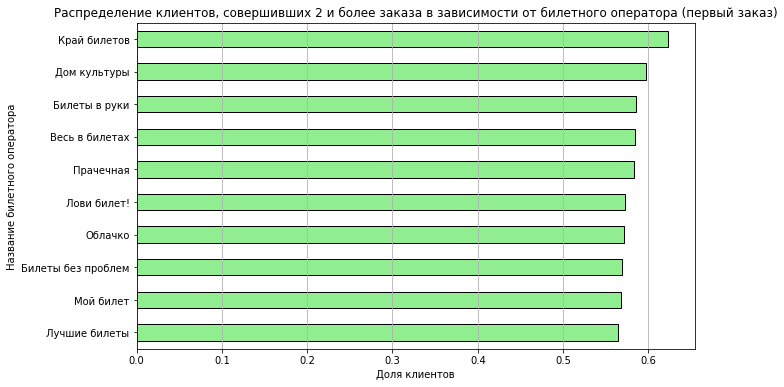

In [122]:
plt.figure(figsize=(10,6))

user_profile[user_profile['service_name_f'].isin(top_services)].groupby('service_name_f')['is_two'].mean().sort_values(ascending=True).plot(kind='barh',color='lightgreen',edgecolor='black')

plt.title('Распределение клиентов, совершивших 2 и более заказа в зависимости от билетного оператора (первый заказ)')
plt.xlabel('Доля клиентов')
plt.ylabel('Название билетного оператора')
plt.grid(axis='x')

plt.show()

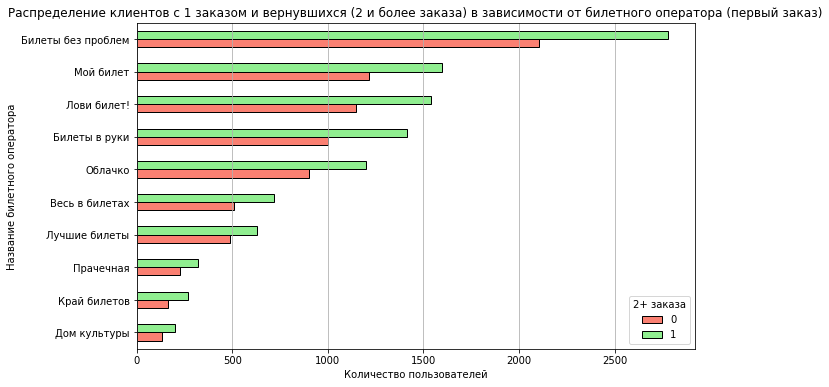

In [123]:
user_profile[user_profile['service_name_f'].isin(top_services)].groupby('service_name_f')['is_two'].value_counts().unstack(fill_value=0).sort_values(by=1).plot(kind='barh',figsize=(10,6),color=['salmon', 'lightgreen'],edgecolor='black')

plt.title('Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от билетного оператора (первый заказ)')
plt.xlabel('Количество пользователей')
plt.ylabel('Название билетного оператора')
plt.grid(axis='x')
plt.legend(title='2+ заказа')

plt.show()

Наивысшая доля возврата наблюдается у операторов «Край билетов» (62.3%) и «Дом культуры» (59.7%), но по численности клиентов они уступают другим. Операторы «Весь в билетах», «Билеты в руки», «Прачечная», «Облачко» — находятся в диапазоне 57–58%, что также свидетельствует о стабильной лояльности и небольшом проценте отрыва от лидирущих билетных операторов. Нижняя часть рейтинга — «Лучшие билеты», «Мой билет», «Билеты без проблем» — с долей возврата около 56–57%. Разница с лидерами составляет около 4–5 процентов. Но при этом они имеют большую клиентскую базу, это может указывать на массовый, но менее удерживаемый трафик. 
Высокая доля возврата не всегда совпадает с большим количеством клиентов. Некоторые операторы работают с более узкой, но лояльной аудиторией, а крупные платформы — с широкой, но менее стабильной.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1:** 

Доля возврата после первого заказа на спортивные мероприятия — около 52%, тогда как после концертов — около 58%. Это означает, что пользователи, начавшие с концертов, возвращаются чаще, чем те, кто начал со спорта. Кроме того, абсолютное число возвратившихся клиентов после концертов — более 5 тыс., что делает этот тип первого посещенного мероприятия не только более лояльным, но и более массовым.  
Тип мероприятия действительно влияет на вероятность возврата, но в обратную сторону, чем предполагает эта гипотеза:
концерты стимулируют повторные покупки чаще, чем спортивные события.

**Гипотеза 1 не подтверждается**

**Гипотеза 2:**

Анализ графика "Распределение клиентов с 1 заказом и вернувшихся (2 и более заказа) в зависимости от региона (первый заказ)", отображающего абсолютные значения показывает, что в крупных регионах — например, Каменевском — действительно больше клиентов и больше повторных заказов в числах. Однако другой график "Распределение клиентов, совершивших 2 и более заказа в зависимости от региона (первый заказ)", отображающего относительные значения демонстрирует, что доля возврата по регионам распределена равномерно, без выраженной зависимости от размера пользовательской базы.  
Это означает, что высокая численность клиентов не гарантирует более высокую лояльность. Некоторые менее активные регионы показывают сопоставимые или даже более высокие доли возврата.  
Следовательно, повторные покупки зависят не столько от общего числа клиентов (их первых заказов) в регионе, сколько от других факторов.

**Гипотеза 2 не подтверждается**

### Промежуточный вывод:

**Задача 4.1.1: Исследование признаков, описывающих первый заказ пользователя, и их влияние на вероятность возвращения пользователя**

Распределение пользователей по сегментам неравномерное, и в данных явно выделяются выраженные «точки входа»:   
- Тип мероприятия: концерты — главный канал привлечения, через них впервые пришли почти половина пользователей (44%)
- Тип устройства: мобильный телефон — доминирующий канал первой покупки (83%), что подтверждает его роль как основной точки входа
- Регионы: Каменевский регион выделяется как крупнейший сегмент (32%)
- Билетные операторы: «Билеты без проблем» лидирует (24%)

Таким образом, данные показывают, что пользователи концентрируются вокруг нескольких ключевых сегментов — концертов, мобильных устройств, отдельных регионов и ведущих билетных операторов. Это подтверждает наличие выраженных точек входа, а не равномерное распределение.

**Задача 4.1.2: Анализ возвратов пользователей**

Анализ разных сегментов показывает, что во всех сегментах вероятность повторного заказа находится примерно на одном уровне, без резких провалов или экстремальных пиков. Ни один фактор (тип мероприятия, устройство, регион, оператор) не оказывает кардинального влияния на возврат. Однако можно выделить лидеров и аутсайдеров в каждом сегменте:  
- Тип мероприятия: самые высокие доли возврата у "выставок" (около 61%) и "театра" (около 60%), а также у "концертов" и "стендапа" (около 57%). При этом именно "концерты" и "театр" дают значимые абсолютные числа возвратов (тысячи клиентов). Минимальная лояльность у "спорта" (около 52%) и "ёлок" (около 55%), но при этом сегмент "ёлки" представлен очень малым числом пользователей, поэтому доля может быть не стабильна.

- Тип устройства: пользователи со стационарных устройств возвращаются чуть чаще (+3%), чем пользователи, совершившие свой первый заказ с мобильного устройства.

- Регион: доли возврата распределены равномерно, лояльность есть во всех регионах. Лидеры по проценту возврата — Светополянский округ и Широковская область (около 61–62%), но численность клиентов не всегда коррелирует с их вероятностью совершить повторный заказ. Самые низкие проценты возврата у Малиновоярского округа и Озернинского края (около 51-52%)

- Билетные операторы: "Край билетов" и "Дом культуры" лидируют по доле возврата (около 60-62%), но имеют небольшую клиентскую базу (по первому заказу). Крупные операторы ("Билеты без проблем", "Мой билет", "Лови билет!") обеспечивают массовый поток клиентов, но с более низкой лояльностью (около 56-57%).

**Задача 4.1.3: Проверка продуктовых гипотез**
- *Гипотеза 1: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.*

Не подтверждается. Концерты стимулируют повторные покупки чаще, чем спортивные события.
- *Гипотеза 2: в регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.* 

Не подтверждается. Высокая численность клиентов не гарантирует более высокие проценты возврата. Некоторые менее активные регионы показывают сопоставимые или даже более высокие доли возврата.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** 

---


Cравнение статистик поля `avg_revenue` для пользователей, совершивших 1 заказ и совершивших 2+ заказа:

In [124]:
user_profile.groupby('is_two')['avg_revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
is_two,,,,,,,,
0,8754.0,541.285217,511.768372,0.0,132.090000,376.794998,824.449997,2594.439941
1,11806.0,541.950073,359.281311,0.0,272.861794,498.844009,749.967514,2275.370117


Гистограмма распределения средней выручки с заказа для пользователей, совершивших один заказ:

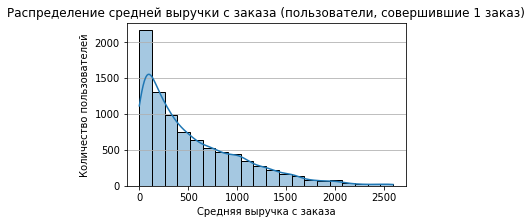

In [125]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_two']==0], x='avg_revenue', bins=20,alpha=0.4,kde=True)

plt.title('Распределение средней выручки с заказа (пользователи, совершившие 1 заказ)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

Гистограмма распределения средней выручки с заказа для пользователей, совершивших 2 и более заказа:

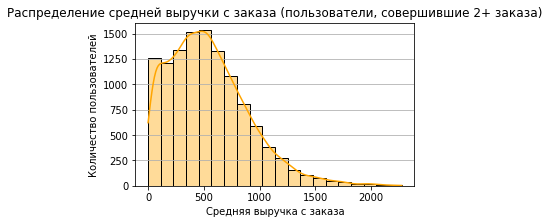

In [126]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_two']==1], x='avg_revenue', bins=20,alpha=0.4,kde=True,color='orange')

plt.title('Распределение средней выручки с заказа (пользователи, совершившие 2+ заказа)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

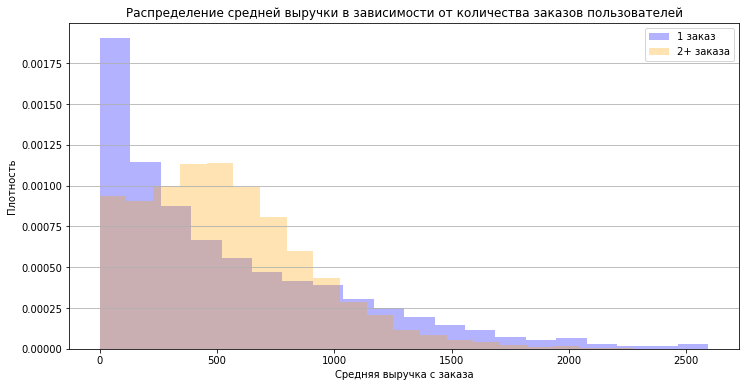

In [128]:
fig, axes = plt.subplots(figsize=(12, 6))

# Первый график (оранжевый): пользователи с 1 заказом
plt.hist(data=user_profile[user_profile['is_two'] == 0],x='avg_revenue',density=True,bins=20,label='1 заказ',color='blue',alpha=0.3)

# Второй график (сиреневый): пользователи с 2-4 заказами
plt.hist(data=user_profile[user_profile['is_two'] == 1],x='avg_revenue',density=True,bins=20,label='2+ заказа',color='orange',alpha=0.3)

plt.title('Распределение средней выручки в зависимости от количества заказов пользователей')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Плотность')
plt.grid(axis='y')
plt.legend()

plt.show()

Пользователи с одним заказом (cиний график):  
Основной пик KDE находится в диапазоне от 0 до 200 руб. средней выручки. Это указывает на то, что большинство таких пользователей совершают недорогие покупки. Имеется пик около значения 0, свидетельствующий о большом количестве клиентов, купивших билеты, стоимость которых принесла сервису околонулевую выручку.

Пользователи с двумя и более заказами (оранжевый график):  
Распределение смещено вправо, с пиком в диапазоне от 350 до 550 руб. Это говорит о более высоком среднем чеке у лояльных пользователей, совершающих повторные покупки.  
Пользователи с 2+ заказами приносят значительно больше выручки за заказ, чем те, кто сделал только один.

---

**Задача 4.2.2.** 

---


Cравнение статистик поля `avg_revenue` для пользователей, совершивших 2-4 заказа и совершивших 5+ заказов:

In [129]:
user_profile[user_profile['is_two']==1]['avg_revenue'].describe()

count    11806.000000
mean       541.950073
std        359.281311
min          0.000000
25%        272.861794
50%        498.844009
75%        749.967514
max       2275.370117
Name: avg_revenue, dtype: float64

In [130]:
user_profile[user_profile['is_five']==1]['avg_revenue'].describe()

count    4374.000000
mean      537.047668
std       275.714935
min         0.000000
25%       345.546463
50%       520.289642
75%       701.745316
max      1986.592041
Name: avg_revenue, dtype: float64

Выше на предыдущем графике (оранжевый цвет) была построена гистограмма распределения значений средней выручки для клиентов с 2+ заказами. Ниже представлен повтор этого графика, чтобы оценить его форму для дальнейшего сравнения:

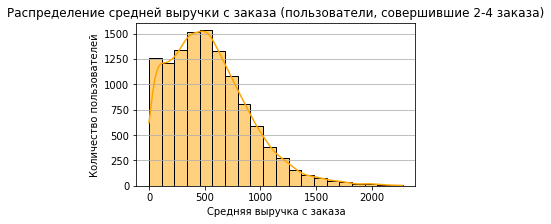

In [131]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_two']==1], x='avg_revenue', bins=20,alpha=0.5,kde=True,color='orange')
plt.title('Распределение средней выручки с заказа (пользователи, совершившие 2-4 заказа)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

Гистограмма распределения средней выручки с заказа для пользователей, совершивших 5 и более заказов:

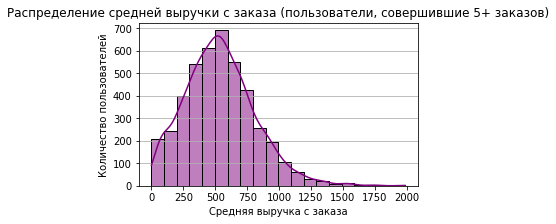

In [132]:
plt.figure(figsize=(5,3))

sns.histplot(data=user_profile[user_profile['is_five']==1], x='avg_revenue', bins=20,alpha=0.5,kde=True,color='purple')

plt.title('Распределение средней выручки с заказа (пользователи, совершившие 5+ заказов)')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

Два графика вместе в одном масштабе:

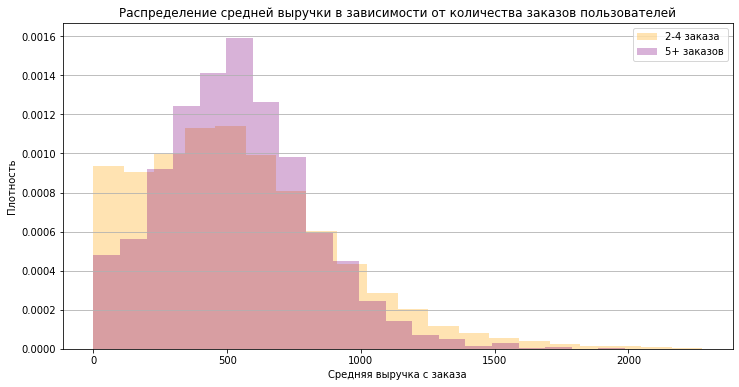

In [134]:
fig, axes = plt.subplots(figsize=(12, 6))

# Первый график (оранжевый): пользователи с 2-4 заказами
plt.hist(data=user_profile[user_profile['is_two'] == 1],x='avg_revenue',density=True,bins=20,label='2-4 заказа',color='orange',alpha=0.3)

# Второй график (сиреневый): пользователи с 5+ заказми
plt.hist(data=user_profile[user_profile['is_five'] == 1],x='avg_revenue',density=True,bins=20,label='5+ заказов',color='purple',alpha=0.3)

plt.title('Распределение средней выручки в зависимости от количества заказов пользователей')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Плотность')
plt.grid(axis='y')
plt.legend()

plt.show()

Распределения средней выручки с заказа для пользователей с 2–4 заказами и 5+ заказами во многом схожи и имеют правостороннюю асимметрию (наличие у обоих групп "хвостов"). График для сегмента 5+ заказов имеет более симметричную форму по сравнению с графиком для сегмента 2-4 заказа.  
У пользователей с 2–4 заказами пик распределения находится примерно в диапазоне 350–550 руб. У пользователей с 5+ заказами пик смещён чуть правее, примерно в диапазон 500–700 руб, и плотность значений выше в этой области. Это говорит о том, что более лояльные пользователи в среднем делают более дорогие заказы. Это также говорит о том, что более лояльные пользователи в среднем совершают немного более дорогие заказы.

---

**Задача 4.2.3.** 

---

Разделение пользователей на несколько сегментов по среднему количеству билетов в заказе:

In [135]:
# Задам функцию, которая сегментирует пользователей по среднему количеству билетов в заказе
def segment_avg_tickets(value):
    if 1 <= value < 2:
        return '1–2 билета'
    elif 2 <= value < 3:
        return '2–3 билета'
    elif 3 <= value < 5:
        return '3–5 билетов'
    elif value >= 5:
        return '5+ билетов'

user_profile['segment_avg_tickets'] = user_profile['avg_tickets'].apply(segment_avg_tickets)

user_profile[['avg_tickets','segment_avg_tickets']].head()

,avg_tickets,segment_avg_tickets
0,4.000000,3–5 билетов
1,3.000000,3–5 билетов
2,2.666667,2–3 билета
3,4.000000,3–5 билетов
4,1.500000,1–2 билета


Общее число пользователей и доля пользователей, совершивших повторные заказы:

In [136]:
user_profile.groupby('segment_avg_tickets')['is_two'].sum().sort_values(ascending=False)

segment_avg_tickets
2–3 билета     6110
3–5 билетов    4632
1–2 билета     1011
5+ билетов       53
Name: is_two, dtype: int64

In [137]:
user_profile.groupby('segment_avg_tickets')['is_two'].mean().sort_values(ascending=False)

segment_avg_tickets
2–3 билета     0.695900
3–5 билетов    0.513184
1–2 билета     0.444787
5+ билетов     0.110187
Name: is_two, dtype: float64

В сегменте, где у пользователя в среднем 2-3 билета в заказе, находится и наибольшее количество клиентов, и их доля возврата составляет около 70%. Сегменты "3-5 билетов" и "1-2" по проценту возврата приблизительно одинаковы (около 51% и 44 %). Сегмент 5+ билетов представлен малым количеством пользователей, поэтому сложно оценить корректную долю возврата в этом случае.

Пользователи распределены по сегментам неравномерно. Основное количество пользователей, совершившие повторные заказы, находятся в сегменте "2-3 билета" и "3-5 билетов".

Распределение пользователей, совершивших повторный заказ, в зависимости от сегмента (по среднему количеству билетов в заказе):

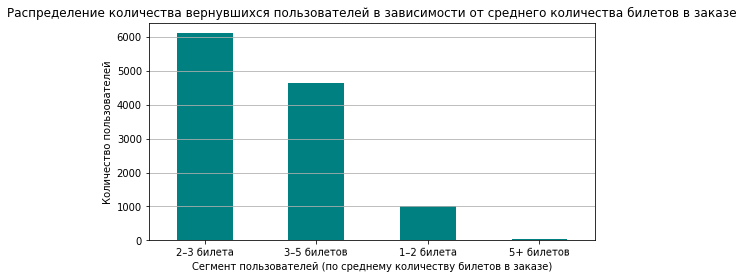

In [138]:
plt.figure(figsize=(8,4))

user_profile.groupby('segment_avg_tickets')['is_two'].sum().sort_values(ascending=False).plot(kind='bar', rot=0.45,color='teal')

plt.title('Распределение количества вернувшихся пользователей в зависимости от среднего количества билетов в заказе')
plt.xlabel('Сегмент пользователей (по среднему количеству билетов в заказе)')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')

plt.show()

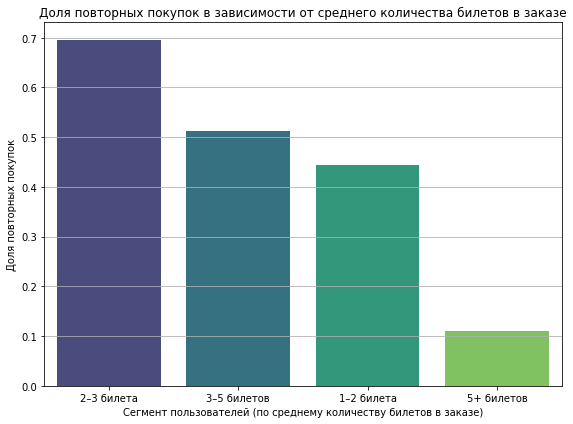

In [139]:
segment_means = user_profile.groupby('segment_avg_tickets')['is_two'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=segment_means.index, y=segment_means.values, palette='viridis')

plt.title('Доля повторных покупок в зависимости от среднего количества билетов в заказе')
plt.ylabel('Доля повторных покупок')
plt.xlabel('Сегмент пользователей (по среднему количеству билетов в заказе)')
plt.grid(axis='y')
plt.tight_layout()

plt.show()


Распределение пользователей неконцентрированное и неравномерное:  
сегмент "2–3 билета" — самый крупный, здесь сосредоточено наибольшее количество клиентов, что делает его основной группой по объёму. Сегменты "1–2 билета" и "3–5 билетов" представлены умеренно — они уступают по численности. Сегмент "5+ билетов" — наименее представленный, его доля в пользовательской базе минимальна.

Аномально высокая доля возврата наблюдается у пользователей с 2–3 билетами в заказе: около 70% совершают повторные покупки. Это самый лояльный сегмент, сочетающий массовость и высокий возврат. У сегментов "1–2 билета" и "3–5 билетов": около 44–51%. Поведение этих групп близкое, без резких отклонений. Аномально низкая доля возврата — у пользователей с 5+ билетами: около 11% совершают повторные покупки.

Высокая доля возврата у пользователей, приобретающих 2–3 билета, может быть связана с особенностями их варианта использования сервиса: такой вариант покупки характерен для небольших компаний, пар или семей, которые регулярно посещают мероприятия вместе. В этом случае покупка билетов становится повторяющимся поведением. 

Сегменты "1–2 билета" и "3–5 билетов" демонстрируют близкие показатели возврата. Это может говорить о более разнородных вариантах использования: часть пользователей совершает разовые покупки, часть — эпизодические, без устойчивой привычки регулярно посещать мероприятия через сервис. 

Аномально низкая доля повторных покупок у пользователей с 5+ билетами может указывать на то, что такие заказы часто носят разовый характер. Вероятно, речь идёт о групповых покупках — например, для организации, школьного класса или корпоративного мероприятия. В таких случаях покупка билетов не отражает личное поведение пользователя и не предполагает дальнейших повторных заказов, что объясняет низкий уровень возврата в этом сегменте. При этом из-за малой численности группы выводы по этому сегменту стоит интерпретировать с осторожностью.

### Промежуточный вывод:

**Задача 4.2.1: Cвязь между средней выручкой сервиса с заказа и повторными заказами**

Пользователи с одним заказом имеют сновной пик в диапазоне от 0 до 200 руб. средней выручки. Большинство таких пользователей совершают недорогие покупки, а также приобретают билеты, стоимость которых принесла сервису околонулевую выручку.  
Для пользователей с двумя и более заказами распределение с пиком расположено в диапазоне от 300 до 600 руб. Это говорит о более высоком среднем чеке у лояльных пользователей, совершающих повторные покупки.  
Пользователи с 2+ заказами приносят значительно больше выручки за заказ, чем те, кто сделал только один.  
Таким образом, пользователи, совершающие повторные покупки, приносят значительно больше выручки за заказ, чем те, кто сделал только один. Это подчёркивает важность удержания клиентов и развития лояльности.


**Задача 4.2.2: Сравнение распределение по средней выручке с заказа в двух группах пользователей: совершивших 2–4 заказа и совершивших 5 и более заказов**

Распределения средней выручки с заказа для пользователей с 2–4 заказами и 5+ заказами во многом схожи и имеют правостороннюю асимметрию (наличие у обоих групп "хвостов"). График для сегмента 5+ заказов имеет более симметричную форму по сравнению с графиком для сегмента 2-4 заказа.  
У пользователей с 2–4 заказами пик распределения находится примерно в диапазоне 350–550 руб. У пользователей с 5+ заказами пик смещён чуть правее, примерно в диапазон 500–700 руб, и плотность значений выше в этой области. Это говорит о том, что более лояльные пользователи в среднем делают более дорогие заказы. Это также говорит о том, что более лояльные пользователи в среднем совершают немного более дорогие заказы.

**Задача 4.2.3: Влияние среднего количества билетов в заказе на вероятность повторной покупки**

Распределение пользователей по сегментам неравномерное: основная масса клиентов находится в группе с 2–3 билетами (6110 пользователей), далее следуют сегменты  "3-5 билетов" (4632 пользователя) и "1-2 билета" (1011 пользователя), а группа 5+ билетов — минимальна (53 пользователя). Сегмент "2–3 билета" демонстрирует наивысшую долю повторных покупок (около 70%), что делает его самым лояльным. Поведение групп "1–2 билета" и "3–5 билетов" схожее (45–51%). Низкий возврат в сегменте 5+ билетов (11%) сложно интерпретировать, поскольку этот сегмент малочисленный, и доля может быть нестабильной.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** 

---


Для удобства последующей группировки и построения визуализаций добавляю в датафрейм <u>user_profile</u> дополнительный столбец с выделенным номером недели из столбца с датой первой покупки `first_order`:

In [140]:
# Прибавляю единицу, чтобы сделать привычный вид, где понедельник - 1, а воскресенье - 7
user_profile['first_order_day'] = user_profile['first_order'].dt.day_of_week + 1

Общее число пользователей, совершивших повторные заказы, в зависимости от номера дня недели:

In [141]:
user_profile[user_profile['is_two'] == 1]['first_order_day'].value_counts()

6    1812
5    1767
2    1726
3    1719
4    1669
1    1645
7    1468
Name: first_order_day, dtype: int64

Суббота и пятница — дни, когда клиенты, совершившие первую покупку, больше всего возвращаются. Минимальное число возвратов - в воскресенье. Вторник, среда, четверг, понедельник находятся в середине диапазона.

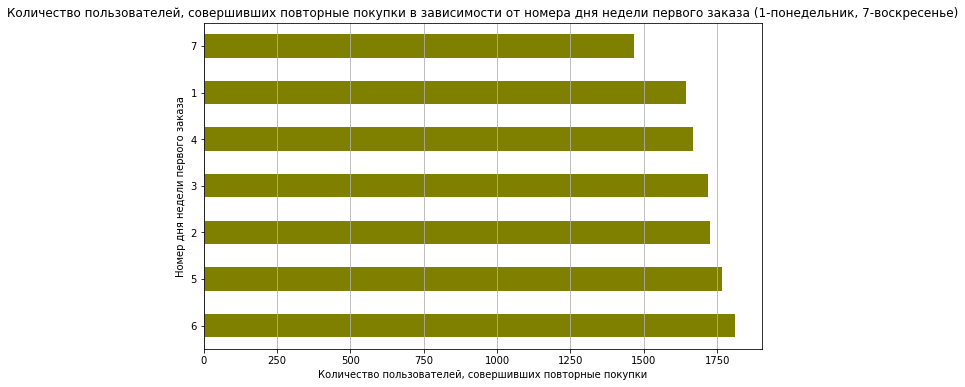

In [142]:
plt.figure(figsize=(10,6))

user_profile.groupby('first_order_day')['is_two'].sum().sort_values(ascending=False).plot(kind='barh',color='olive')

plt.title('Количество пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.ylabel('Номер дня недели первого заказа')
plt.xlabel('Количество пользователей, совершивших повторные покупки')
plt.grid(axis='x')

plt.show()

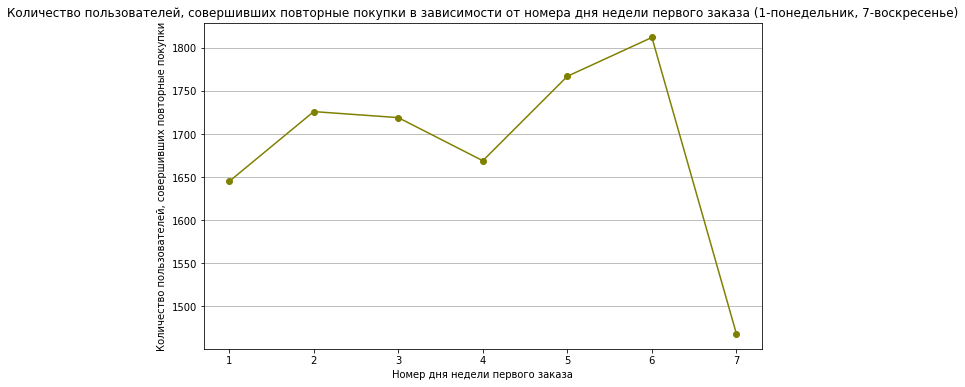

In [143]:
plt.figure(figsize=(10,6))

plt.plot(range(1,8),user_profile[user_profile['is_two'] == 1]['first_order_day'].value_counts().sort_index().values,marker='o',color='olive')

plt.title('Количество пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.xlabel('Номер дня недели первого заказа')
plt.ylabel('Количество пользователей, совершивших повторные покупки')
plt.grid(axis='y')

plt.show()

Визуализация выше также подтверждает, что люди, совершающие первую покупку в субботу, чаще возвращаются. Это может говорить о более осознанных покупках в выходные, когда у клиентов больше времени.

Воскресенье — самый слабый день для удержания. Возможно, в воскресенье клиенты совершают импульсивные заказы, не планируя возвращаться. Или это могут быть остатки рекламных кампаний.

Доля пользователей, совершивших повторные заказы, в зависимости от номера дня недели:

In [144]:
user_profile.groupby('first_order_day')['is_two'].mean().sort_values(ascending=False)

first_order_day
1    0.591301
3    0.587893
6    0.584139
2    0.575525
5    0.562560
7    0.561162
4    0.557076
Name: is_two, dtype: float64

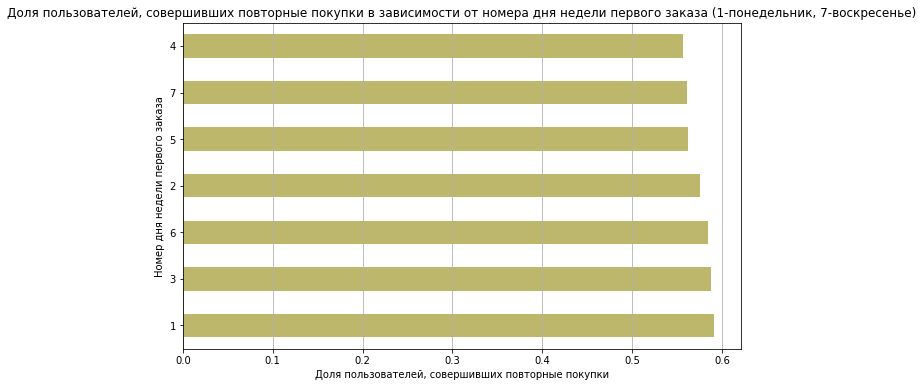

In [145]:
plt.figure(figsize=(10,6))

user_profile.groupby('first_order_day')['is_two'].mean().sort_values(ascending=False).plot(kind='barh',color='darkkhaki')

plt.title('Доля пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.ylabel('Номер дня недели первого заказа')
plt.xlabel('Доля пользователей, совершивших повторные покупки')
plt.grid(axis='x')

plt.show()

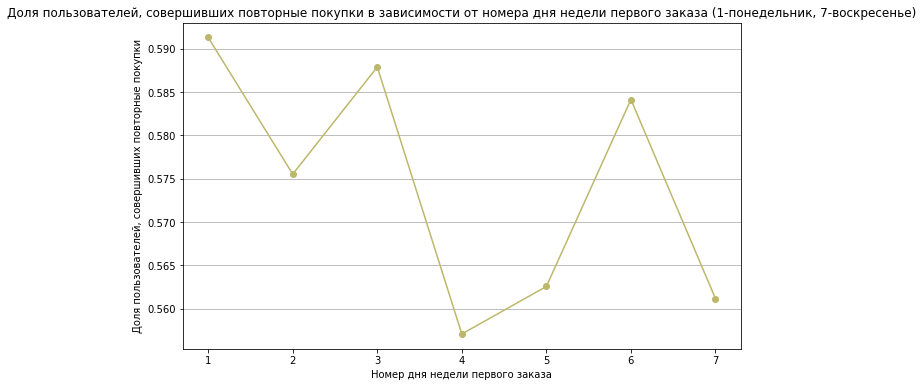

In [146]:
plt.figure(figsize=(10,6))

plt.plot(range(1,8),user_profile.groupby('first_order_day')['is_two'].mean().sort_index().values,marker='o',color='darkkhaki')

plt.title('Доля пользователей, совершивших повторные покупки в зависимости от номера дня недели первого заказа (1-понедельник, 7-воскресенье)')
plt.xlabel('Номер дня недели первого заказа')
plt.ylabel('Доля пользователей, совершивших повторные покупки')
plt.grid(axis='y')

plt.show()

Понедельник — лидер по лояльности. Хотя по абсолютному числу возвратов (из данных выше) понедельник был ближе к нижней части списка, по доле он на первом месте. Это значит, что клиенты, пришедшие в понедельник, чаще возвращаются, несмотря на то, что их было меньше. Возможно, это клиенты, совершающие обдуманные и осознанные покупки в начале рабочей недели.

Суббота — не самая лояльная,поскольку по количеству возвратов суббота была на первом месте, но по доле — только третья. Это может говорить о большом трафике, но не обязательно о высоком качестве: часть клиентов могла быть случайной или пришла по акции.

Воскресенье — самый слабый день по всем метрикам: и по количеству, и по доле — самый низкий результат.

Клиенты, совершившие первую покупку в среду, возвращаются почти так же часто, как и те, кто начал в понедельник. Это говорит о высоком качестве аудитории в середине недели.В отличие от выходных, где наблюдаются сильные колебания (суббота — много клиентов, но не самая высокая доля; воскресенье — минимум по всем метрикам), середина недели показывает устойчивую и надёжную конверсию в повторные заказы. Среда может быть днём, когда клиенты совершают более осознанные покупки — не импульсивные, а плановые. Это повышает вероятность возврата.

---

**Задача 4.3.2.** 

---


Среднее время между заказами для пользователей, совершивших 2-4 заказа:

In [147]:
user_profile[user_profile['is_two']==1]['avg_time'].mean().round(2)

19.61

Среднее время между заказами для пользователей, совершивших 5+ заказов:

In [148]:
user_profile[user_profile['is_five']==1]['avg_time'].mean().round(2)

13.5

Для пользователей, которые совершают 2-4 заказа, среднее время между заказами составляет около 20 дней. У пользователей, совершающих 5 и более заказов среднее время между заказами составляет около 14 дней.

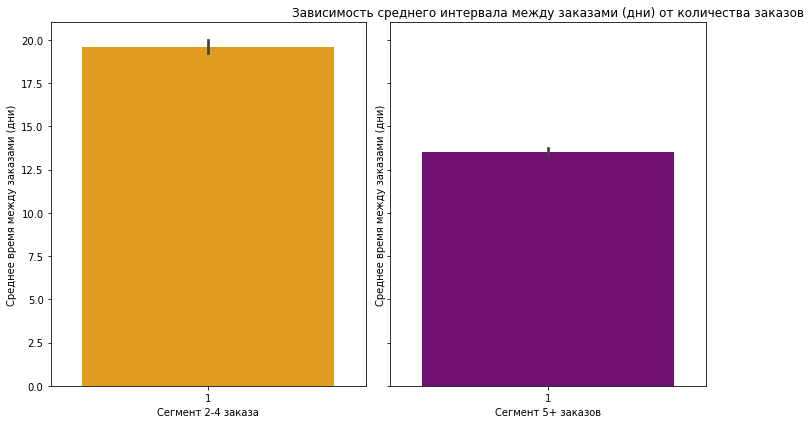

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Первый график (оранжевый): для пользователей с 2-4 заказами
sns.barplot(data=user_profile[user_profile['is_two'] == 1],x='is_two',y='avg_time',color='orange',ax=axes[0])
axes[0].set_ylabel('Среднее время между заказами (дни)')
axes[0].set_xlabel('Сегмент 2-4 заказа')

# Второй график (сиреневый): для пользоватеелй с 5+ заказами
sns.barplot(data=user_profile[user_profile['is_five'] == 1], x='is_five', y='avg_time', color='purple', ax=axes[1])
axes[1].set_ylabel('Среднее время между заказами (дни)')
axes[1].set_xlabel('Сегмент 5+ заказов')

plt.title('Зависимость среднего интервала между заказами (дни) от количества заказов')
plt.tight_layout()

plt.show()

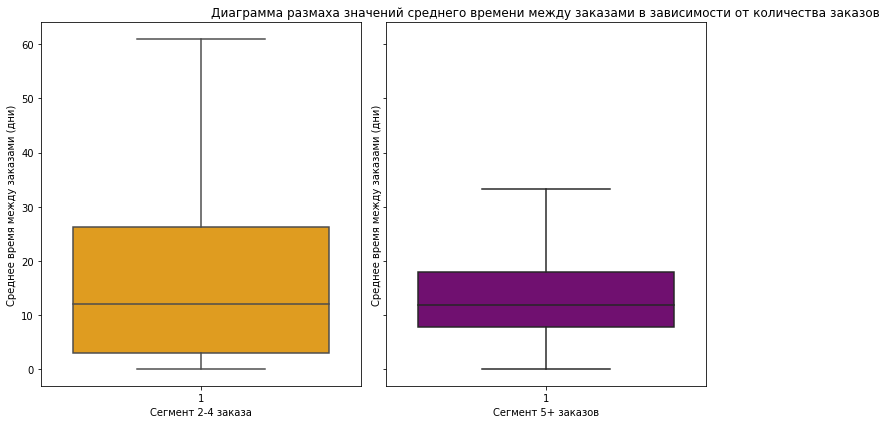

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Первый график для пользователей с 2-4 заказами
sns.boxplot(data=user_profile[user_profile['is_two'] == 1],x='is_two',y='avg_time',showfliers=False,color='orange',ax=axes[0])
axes[0].set_xlabel('Сегмент 2-4 заказа')
axes[0].set_ylabel('Среднее время между заказами (дни)')

# Второй график для пользоватеелй с 5+ заказами
sns.boxplot(data=user_profile[user_profile['is_five'] == 1],x='is_five',y='avg_time',showfliers=False,color='purple',ax=axes[1])
axes[1].set_xlabel('Сегмент 5+ заказов')
axes[1].set_ylabel('Среднее время между заказами (дни)')

plt.title('Диаграмма размаха значений среднего времени между заказами в зависимости от количества заказов')
plt.tight_layout()

plt.show()


Чем меньше интервал между заказами, тем выше вероятность удержания: пользователи, совершившие 5+ заказов, делают это с меньшим средним интервалом (около 13 дней между заказами), чем те, кто совершил 2–4 заказа (около 20 дней между заказами).  
Клиенты с короткими интервалами между заказами демонстрируют устойчивое поведение и склонность к повторным покупкам. Диаграммы размаха подтверждают это наблюдение: у сегмента с 5+ заказами распределение интервалов более компактное, с меньшим разбросом, тогда как у группы 2–4 заказов наблюдается широкий диапазон, включая длительные паузы между заказами.

**Исследование времени с момента первой покупки — лайфтайм:**

In [151]:
# Создание дополнительного столбца со значением лайфтайма
user_profile['lifetime_days'] = (user_profile['last_order'] - user_profile['first_order']).dt.days

user_profile[['first_order','last_order','lifetime_days']].head()

,first_order,last_order,lifetime_days
0,2024-08-20,2024-08-20,0
1,2024-07-23,2024-10-06,75
2,2024-07-13,2024-10-23,102
3,2024-08-15,2024-08-15,0
4,2024-09-29,2024-10-15,16


In [152]:
user_profile[user_profile['is_two'] == 1]['lifetime_days'].describe()

count    11806.000000
mean        59.616890
std         50.167862
min          0.000000
25%          7.000000
50%         54.000000
75%        106.000000
max        152.000000
Name: lifetime_days, dtype: float64

In [153]:
user_profile[user_profile['is_five'] == 1]['lifetime_days'].describe()

count    4374.000000
mean       98.018747
std        39.714170
min         0.000000
25%        71.000000
50%       109.000000
75%       131.000000
max       152.000000
Name: lifetime_days, dtype: float64

Гистограмма распределения:

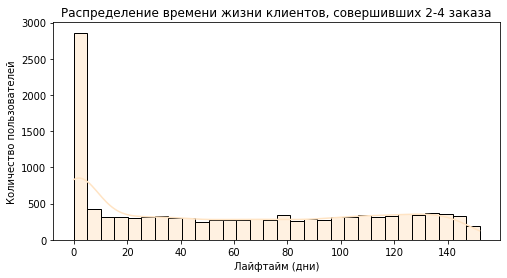

In [154]:
plt.figure(figsize=(8,4))

sns.histplot(user_profile[user_profile['is_two'] == 1]['lifetime_days'],bins=30,kde=True,color='bisque') 

plt.title('Распределение времени жизни клиентов, совершивших 2-4 заказа')
plt.xlabel('Лайфтайм (дни)')
plt.ylabel('Количество пользователей')


plt.show()

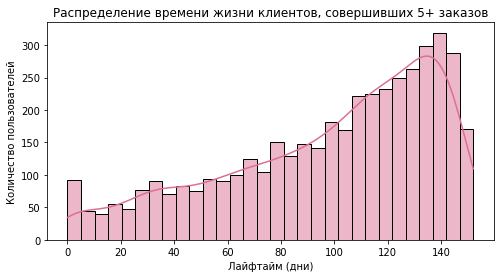

In [155]:
plt.figure(figsize=(8,4))

sns.histplot(user_profile[user_profile['is_five'] == 1]['lifetime_days'],bins=30,kde=True,color='palevioletred') 

plt.title('Распределение времени жизни клиентов, совершивших 5+ заказов')
plt.xlabel('Лайфтайм (дни)')
plt.ylabel('Количество пользователей')


plt.show()

У клиентов с 2–4 заказами: Среднее арифметическое (около 59 дней) больше медианы (54 дня). Разброс значений от 0 до 152 дней. У клиентов с 5+ заказами: Среднее арифметическое (около 98 дней) меньше медианы (109 дней). Разброс точно такой же, как и в сегменте "2-4 заказа". Клиенты с большим числом заказов остаются активными дольше, с более устойчивым лайфтаймом.

Диаграммы размаха значений лайфтайма от количества заказов:

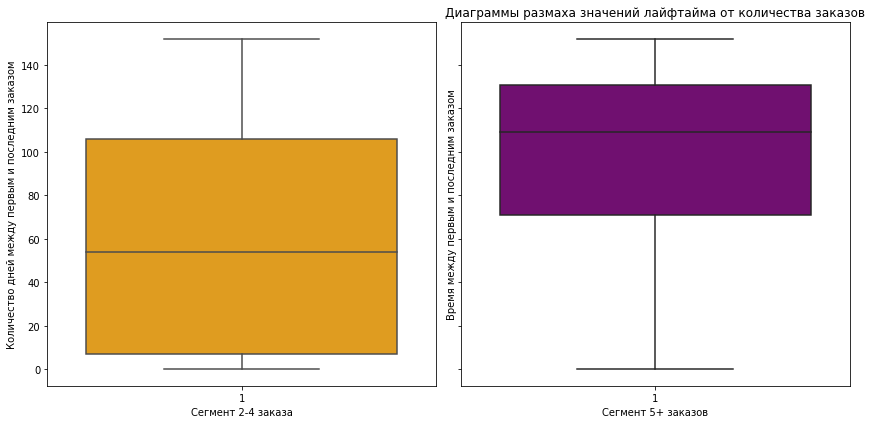

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Первый график для пользователей с 2-4 заказами
sns.boxplot(data=user_profile[user_profile['is_two'] == 1],x='is_two',y='lifetime_days',showfliers=False,color='orange',ax=axes[0])
axes[0].set_xlabel('Сегмент 2-4 заказа')
axes[0].set_ylabel('Количество дней между первым и последним заказом')

# Второй график для пользоватеелй с 5+ заказами
sns.boxplot(data=user_profile[user_profile['is_five'] == 1],x='is_five',y='lifetime_days',showfliers=False,color='purple',ax=axes[1])
axes[1].set_xlabel('Сегмент 5+ заказов')
axes[1].set_ylabel('Время между первым и последним заказом')

plt.title('Диаграммы размаха значений лайфтайма от количества заказов')
plt.tight_layout()

plt.show()


Клиенты с 5+ заказами имеют более длительный лайфтайм: медиана лайфтайма у этой группы выше, чем у клиентов с 2–4 заказами. Это логично, поскольку чтобы совершить 5+ заказов, нужно больше времени активности. Разброс значений у 2–4 заказов шире, то есть у клиентов с таким количеством заказов лайфтайм варьируется от очень короткого до очень длинного. Это говорит о большей вариативности: часть клиентов быстро перестаёт заказывать, часть остаётся надолго, но не переходит к частым покупкам. 

### Промежуточный вывод:

**Задача 4.3.1: Анализ влияния дня недели, в который была совершена первая покупка, на поведение пользователей**   

По количеству возвратных клиентов лидируют суббота (1812) и пятница (1767), минимальное значение у воскресенья (1468). Будние дни (вторник–четверг) находятся в среднем диапазоне, понедельник чуть ниже.  
Наибольшая доля возвратных клиентов у понедельника (59%) и среды (около 59%), далее идут суббота и вторник. Наименьшие показатели у воскресенья (56%) и четверга (около 56%).  
Суббота характеризуется максимальным числом возвратов, но по доле занимает лишь третье место. Понедельник и среда не самые большие по числу, но лидеры по доле — более "лояльные" дни. Воскресенье слабый день по обеим метрикам — и по числу, и по доле возвратов.  
Таким образом, данные показывают различие между "популярностью" дня (общее число клиентов) и "качеством" дня (доля возвратов), что позволяет выделить понедельник и среду как наиболее устойчивые по лояльности, а субботу и пятницу — как дни с наибольшим трафиком, но не самой высокой долей возвратов.


**Задача 4.3.2: Влияние среднего интервала между заказами на удержание клиентов**

Чем меньше интервал между заказами, тем выше вероятность удержания: пользователи, совершившие 5+ заказов, делают это с меньшим средним интервалом (около 13 дней между заказами), чем те, кто совершил 2–4 заказа (около 20 дней между заказами). Клиенты с короткими интервалами между заказами демонстрируют устойчивое поведение и склонность к повторным покупкам. Более длинные интервалы могут свидетельствовать о снижении интереса, особенно если клиент не переходит из сегмента 2-4 заказа к 5+ заказам. Средний интервал — важный индикатор удержания, и его сокращение связано с ростом числа заказов и лояльностью клиента.

**Анализ лайфтайма пользователей** :

У клиентов с 2–4 заказами среднее арифметическое (около 59 дней) больше медианы (54 дней). У клиентов с 5+ заказами среднее арифметическое (около 98 дней) меньше медианы (109 дней). Разброс значений одинаков для обоих сегментов. Из этой информации можно заключить, что клиенты с большим числом заказов остаются активными дольше, с более устойчивым лайфтаймом.
Лайфтайм прямо связан с числом заказов: чем больше заказов, тем дольше клиент остаётся активным. Клиенты с 2–4 заказами — менее предсказуемые, среди них есть как быстро исчезающие, так и потенциально лояльные, но не активные. Клиенты с 5+ заказами — устойчивый сегмент с длительным и стабильным лайфтаймом.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** 

---

In [157]:
# Создание корреляционной матрицы
corr_matrix = user_profile[['total_orders','device_type_f','region_f','service_name_f','event_type_f','first_order_day','avg_revenue','avg_tickets','avg_time']].phik_matrix(interval_cols=['avg_revenue','avg_tickets','avg_time'])

correlation_matrix = corr_matrix.loc[corr_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

correlation_matrix

,total_orders
avg_tickets,0.602318
avg_time,0.520597
avg_revenue,0.285923
device_type_f,0.045501
event_type_f,0.038135
first_order_day,0.036898
region_f,0.000000
service_name_f,0.000000


Тепловая карта:

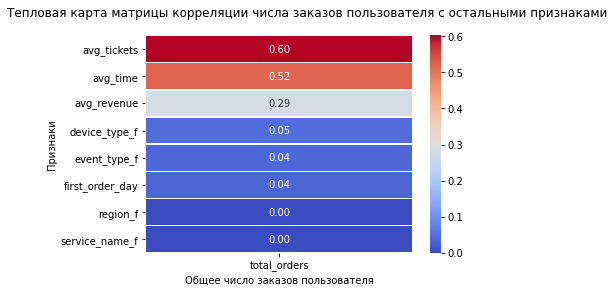

In [158]:
sns.heatmap(data=correlation_matrix,annot=True,fmt='.2f',linewidths=0.5,cmap='coolwarm')

plt.suptitle('Тепловая карта матрицы корреляции числа заказов пользователя с остальными признаками')
plt.xlabel('Общее число заказов пользователя')
plt.ylabel('Признаки')

plt.show()

Корреляция различных признаков с общим числом заказов пользователя:

`avg_tickets` — самая сильная корреляция. Среднее количество билетов в заказе тесно связано с общим числом заказов.  
`avg_time` — также значимая связь. Среднее время между заказами влияет на их количество.

`avg_revenue` — умеренная корреляция. Средний доход от клиента связан с числом заказов, но слабее, чем количество билетов и частота покупок.

`device_type_f` и `event_type_f`,`first_order_day` — очень слабая связь. Тип устройства, тип первого мероприятия и день первого заказа практически не влияют на количество заказов.  
`region_f`, `service_name_f`  — отсутствует корреляция. Регион и билетный оператор не оказывают влияния на общее число заказов.

Выделяю сегменты пользователей по полю `total_orders`, и повторяю корреляционный анализ:

In [159]:
# Функция, которая сегментирует пользователей по количеству заказов
def segment_avg_orders(value):
    if value ==1:
        return '1 заказ'
    elif 2 <= value <= 4:
        return '2–4 заказа'
    elif value >= 5:
        return '5+ заказов'

user_profile['segment_total_orders'] = user_profile['total_orders'].apply(segment_avg_orders)

user_profile[['total_orders','segment_total_orders']]

,total_orders,segment_total_orders
0,1,1 заказ
1,2,2–4 заказа
2,3,2–4 заказа
3,1,1 заказ
4,2,2–4 заказа
...,...,...
21817,7,5+ заказов
21818,2,2–4 заказа
21819,25,5+ заказов
21820,1,1 заказ


In [160]:
# Создание новой корреляционной матрицы
corr_matrix = user_profile[['segment_total_orders','device_type_f','region_f','service_name_f','event_type_f','first_order_day','avg_revenue','avg_tickets','avg_time']].phik_matrix(interval_cols=['avg_revenue','avg_tickets','avg_time'])

correlation_matrix = corr_matrix.loc[corr_matrix.index != 'segment_total_orders'][['segment_total_orders']].sort_values(by='segment_total_orders', ascending=False)

correlation_matrix

,segment_total_orders
avg_tickets,0.662392
avg_time,0.384079
avg_revenue,0.336801
region_f,0.119265
service_name_f,0.071819
event_type_f,0.039877
first_order_day,0.025098
device_type_f,0.017674


Тепловая карта:

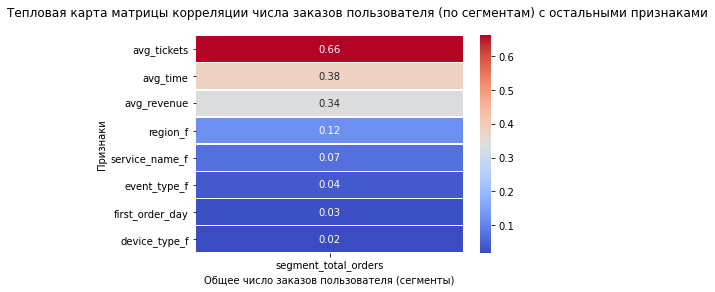

In [161]:
sns.heatmap(data=correlation_matrix,annot=True,fmt='.2f',linewidths=0.5,cmap='coolwarm')

plt.suptitle('Тепловая карта матрицы корреляции числа заказов пользователя (по сегментам) с остальными признаками')
plt.xlabel('Общее число заказов пользователя (сегменты)')
plt.ylabel('Признаки')

plt.show()

`avg_tickets` — самая сильная связь. Среднее количество билетов в заказе наиболее сильно связано с тем, в какой сегмент по числу заказов попадает клиент.  
`avg_time` — умеренная связь. Интервалы между заказами влияют на количество заказов. `avg_revenue` — также умеренная связь. Средний доход от клиента коррелирует с числом заказов, но слабее, чем количество билетов и частота покупок.

`region_f` и `service_name_f` — слабая связь. Регион и билетный оператор оказывают ограниченное влияние на количество заказов.

`event_type_f`, `first_order_day`, `device_type_f`  — практически не связаны с числом заказов. Тип мероприятия, день первого заказа и устройство не определяют количество заказов клиента.

### Промежуточный вывод: 

**Задача 4.4.1: Корреляционный анализ между признаками профиля пользователя и числом заказов total_orders**

Основными факторами, определяющими сегмент клиента по числу заказов, являются среднее количество билетов в заказе (`avg_tickets`) и частота покупок (`avg_time`). Финансовый показатель (`avg_revenue`) играет второстепенную роль. Остальные признаки — регион, оператор, тип мероприятия, устройство и день первого заказа — оказывают минимальное влияние.

Повторные покупки клиентов в большей степени объясняются их поведенческими характеристиками, чем демографией или первым выбором сервиса. Ключевыми факторами сегментации по числу заказов являются среднее количество билетов в заказе (`avg_tickets`) и частота покупок (`avg_time`). Эти признаки отражают реальное взаимодействие пользователя с сервисом и дают более точное представление о его склонности к повторным заказам. Финансовый показатель (`avg_revenue`) оказывает умеренное влияние, а такие параметры, как регион, оператор, тип мероприятия, устройство и день первого заказа, играют минимальную роль в объяснении повторного поведения.

### 5. Общий вывод и рекомендации


**Информация об используемых данных**

При выгрузке из базы данных был получен датасет <u>df</u>, включающий в себя информацию о 290 611 заказах и 15 различных признаков. Подготовка к анализу включала в себя: 
- Преобразование типов данных столбцов
- Оптимизацию типов данных столбцов
- Создание дополнительного признака `revenue_rub`, хранящего в себе значения выручки с заказа в российских рублях. Поскольку в датафрейме информация о выручке содержалась в двух валютах (российский рубль, казахстанский тенге), был загружен и использован для конвертации валют датасет <u>df_tenge</u>. 
- Удаление неполных дубликатов
- Удаление данных с отрицательными значениями выручки
- Фильтрация данных по значению 99% процентиля выручки в российских рублях.

Данные представлены для заказов, сделанных с мобильных устройств и стационарных устройств. Заказы были оплачены двумя видами валют: тенге, российский рубль. Билеты приобретались на различные типы мероприятий: выставки, концерты, спорт, стендап, театр, ёлки, другое. Заказы совершались из большого числа различных регионов и городов.

На основе датафрейма <u>df</u> создан датафрейм <u>user_profile</u>, содержащий в себе информацию о пользователях и формирующий профиль пользователя по 13 признакам. До преобразований включал в себя информацию о 21 822
пользователях. 
После исследования статистических характеристик числовых столбцов были проведены:
- Фильтрация данных по значению 95% процентиля количества заказов на одного пользователя
- Фильтрация данных по значению 99% процентиля среднего количества билетов в заказе пользователя
После фильтрации размер датафрейма был уменьшен до 20 553 пользователей (менее 6% данных отфильтровано).
В ходе исследований в <u>user_profile</u> добавлены следующие признаки:
- `segment_avg_tickets` - сегментация пользователей по среднему количеству билетов в заказе
- `first_order_day` - номер дня недели первой покупки 
- `lifetime_days` - лайфтайм пользователя (время между первой и последней покупками)
- `segment_total_orders` - сегментация пользователей по общему количеству заказов

**Исследовательский анализ данных**

В ходе исследования проанализированы данные 20 560 пользователей, средняя выручка с одного заказа - 541 руб., процент пользователей, совершивших 2 и более заказа - 57% , процент пользователей, совершивших 5 и более заказов - 21% .

1. Анализ показал, что признаки первого заказа слабо дифференцируют пользователей по вероятности возврата. В данных нет факторов, которые бы радикально повышали или снижали шанс повторной покупки. Тем не менее, можно выделить умеренные различия:

- Наиболее высокие доли повторных заказов наблюдаются у пользователей, начавших с: выставок и театра, концертов и стендапа. При этом именно концерты и театр формируют основной абсолютный объём возвратов, так как являются крупнейшими точками входа. Спортивные мероприятия и "ёлки" демонстрируют более низкую лояльность, но в случае "ёлок" выводы ограничены малым размером сегмента, поскольку данные представлены за летний и часть осеннего периода.

- Пользователи, сделавшие первый заказ со стационарных устройств, возвращаются немного чаще (+3%), однако мобильные устройства остаются ключевым каналом привлечения.

- Регион и билетный оператор: доли возврата распределены достаточно равномерно. Высокая численность пользователей в регионе или у оператора не гарантируют высокой лояльности. Небольшие операторы (по численности первых заказов) демонстрируют более высокие проценты возврата, но формируют малый объём повторных клиентов, тогда как крупные операторы дают массовый приток при средней лояльности.

- Признаки первого заказа задают "точку входа", но не определяют поведение клиента в долгосрочной перспективе.

2. Средняя выручка с заказа: пользователи с одним заказом сконцентрированы в низком ценовом диапазоне (0–200 руб.), пользователи с 2+ заказами имеют значительно более высокий средний чек (300–500 руб.). Различия между сегментами 2–4 и 5+ заказов есть, но они менее выражены, чем между 1 и 2+ заказами. При этом у клиентов с 5+ заказами наблюдается пик в больших значениях).

- Количество билетов в заказе можно выявить следующие сегменты: самый лояльный сегмент — 2–3 билета (около 70% возврата), сегменты 1–2 и 3–5 билетов демонстрируют заметно более низкие показатели (около 55–52%), сегмент 5+ билетов слишком малочисленный для устойчивых выводов.

- Оптимальный по лояльности профиль — средний чек и 2–3 билета в заказе. Поведение "минимального" и "слишком крупного" заказа менее устойчивые.

3. День недели первой покупки: по абсолютному числу возвратов лидируют пятница и суббота (высокий трафик), по доле возвратов — понедельник и среда (более "качественные" дни), воскресенье показывает наихудшие результаты и по числу, и по доле повторных заказов. Это указывает на различие между днями привлечения массового спроса и днями формирования более лояльной аудитории.

- Клиенты с 5+ заказами имеют более короткий средний интервал между покупками (около 11 дней), у клиентов с 2–4 заказами интервал больше (около 17 дней). Чем меньше интервал между заказами, тем выше вероятность удержания и роста числа покупок.
Клиенты с большим числом заказов остаются активными дольше и демонстрируют более стабильное поведение.

- Временная динамика (частота и регулярность покупок) является одним из ключевых факторов удержания.

4. Корреляционный анализ показал, что наибольшее влияние на число заказов оказывают: среднее количество билетов в заказе, частота покупок (интервалы между заказами). Финансовые показатели (средняя выручка) играют второстепенную роль. Признаки первого заказа и профиля пользователя (регион, оператор, тип мероприятия, устройство, день недели) оказывают минимальное влияние.



**Рекомендации для заказчика**

Главными факторами, определяющими активность и сегмент клиента, являются поведенческие метрики — количество билетов и частота заказов. Финансовые показатели играют второстепенную роль, а внешние характеристики (регион, билетный оператор, устройство, день первого заказа) почти не влияют.

1. *Сегменты, на которые стоит обратить внимание в первую очередь*

- Пользователи с 2–3 билетами в заказе. Это самый лояльный сегмент, поскольку у них самая высокая доля повторных покупок. Можно поддерживать их интерес персональными рекомендациями, предлагать похожие мероприятия.

- Пользователи с 2–4 заказами. Это очень важный сегмент роста, поскольку они уже возвращаются, но ещё не стали полностью стабильными клиентами, часть из них может перейти в сегмент 5+ заказов. Для них имеет смысл напоминать о новых событиях через короткое время после покупки, предлагать бонусы или небольшие скидки за следующий заказ, иными методами сокращать паузу между покупками.

2. *Сегменты, которым нужны дополнительные маркетинговые усилия*

- Пользователи с одним заказом и низким средним чеком - это самая массовая, но наименее лояльная группа. Именно здесь наблюдается наибольший отток, поэтому: важно мотивировать их сделать второй заказ, можно использовать промокоды, подборки популярных мероприятий, напоминания.

- Пользователи с длинными интервалами между заказами. Чем больше пауза между покупками, тем ниже вероятность, что клиент вернётся. Для таких пользователей можно напоминать о сервисе через персональные рассылки, предлагать мероприятия, похожие на первый заказ.

3.  Анализ показал, что понедельник и среда отличаются более высокой долей возвратных клиентов. Это значит, что именно в эти дни имеет смысл запускать акции и коммуникации, направленные на долгосрочное удержание. Если усиливать трафик в эти дни, есть шанс привлечь более лояльную аудиторию. Пятница и суббота дают много новых пользователей, но их лояльность ниже, поэтому эти дни скорее подходят для привлечения, а не для удержания.
